# Set Up

## Imports

TUNE XGBOOST GPU, USE KERAS TUNER FOR MLP JUST AUDIO GENRES 

In [101]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

#Standard Libraries
import os
from os import listdir
import pickle
#import optuna
import librosa
import numpy as np
import pandas as pd
from datetime import datetime

#Plots and Visuals
import re
import black
import shap
#import jupyter_black
#jupyter_black.load(lab=True, line_length=120)

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (16, 6)
plt.style.use('ggplot')
sns.set_style("darkgrid")
from scipy import stats

#Sci-kit Learn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import xgboost as xg

#Keras - Tensorflow
import keras
import keras_tuner as kt
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import Model
from keras.layers import (
    Input, Flatten, Normalization, Embedding, Dense, Dropout, SpatialDropout2D, Activation,
    Conv1D, Conv2D, BatchNormalization, MaxPooling1D, MaxPooling2D, GlobalAvgPool1D, GlobalAveragePooling2D, LeakyReLU,
    Concatenate, Reshape, Bidirectional, GRU, LSTM, TimeDistributed, GlobalMaxPooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2

#from keras.applications import VGG16

## Load Data 

In [2]:
# Spotify Features
with open("spotify_features.pkl", "rb") as z:
    (X_audio_train, X_audio_val, X_audio_test) = pickle.load(z)

# Genres
with open("genres.pkl", "rb") as z:
    (X_genres_train, X_genres_val, X_genres_test) = pickle.load(z)

# Mel Spectrograms
with open("mel_spectrograms.pkl", "rb") as z:
    (X_mel_train, X_mel_val, X_mel_test) = pickle.load(z)

# Mel Features
with open("mfccs.pkl", "rb") as z:
    (X_mel_features_train, X_mel_features_val, X_mel_features_test) = pickle.load(z)
    
# Youtube Views
with open("youtube_views.pkl", "rb") as z:
    (X_views_train, X_views_val, X_views_test) = pickle.load(z)

with open("static_views.pkl", "rb") as z:
    (X_static_views_train, X_static_views_val, X_static_views_test) = pickle.load(z)

# Target
with open("target.pkl", "rb") as z:
    (y_train, y_val, y_test) = pickle.load(z)

print(list(X_audio_train.columns))

['explicit', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'valence', 'year', 'month', 'time_signature_1.0', 'time_signature_3.0', 'time_signature_4.0', 'time_signature_5.0', 'key_1.0', 'key_2.0', 'key_3.0', 'key_4.0', 'key_5.0', 'key_6.0', 'key_7.0', 'key_8.0', 'key_9.0', 'key_10.0', 'key_11.0']


In [3]:
X_static_views_train = X_static_views_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_static_views_val = X_static_views_val.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X_static_views_test = X_static_views_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [4]:
X_before_train = X_audio_train.merge(X_genres_train, on="id", how="outer").merge(
    X_mel_features_train, on="id", how="outer")
X_before_val = X_audio_val.merge(X_genres_val, on="id", how="outer").merge(
    X_mel_features_val, on="id", how="outer")
X_before_test = X_audio_test.merge(X_genres_test, on="id", how="outer").merge(
    X_mel_features_test, on="id", how="outer")

X_after_train = X_audio_train.merge(X_genres_train, on="id", how="outer").merge(
    X_mel_features_train, on="id", how="outer").merge(X_static_views_train, on="id", how="outer")
X_after_val = X_audio_val.merge(X_genres_val, on="id", how="outer").merge(
    X_mel_features_val, on="id", how="outer").merge(X_static_views_val, on="id", how="outer")
X_after_test = X_audio_test.merge(X_genres_test, on="id", how="outer").merge(
    X_mel_features_test, on="id", how="outer").merge(X_static_views_test, on="id", how="outer")

#Combine train and validation data to use for CV for before
X_before = pd.concat([X_before_train, X_before_val])
#Combine train and validation data to use for CV for after
X_after = pd.concat([X_after_train,X_after_val])

y = pd.concat([y_train, y_val])

## Functions 

In [5]:
def plot_learning_curves(model_history):
    # Plotting the MSE and the loss learning curves side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    MSE = model_history["mse"]
    val_MSE = model_history["val_mse"]
    epochs = range(1, len(MSE) + 1)
    ax1.plot(epochs, MSE, "g--", label="Training MSE")
    ax1.plot(epochs, val_MSE, "g", label="Validation MSE")
    ax1.set_title("Training and validation MSE", fontsize=15)
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("MSE")
    ax1.legend()
    loss = model_history["loss"]
    val_loss = model_history["val_loss"]
    ax2.plot(epochs, loss, "r--", label="Training loss")
    ax2.plot(epochs, val_loss, "r", label="Validation loss")
    ax2.set_title("Training and validation loss", fontsize=15)
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Loss")
    ax2.legend()
    return plt.show()

In [6]:
def report(model, X):
    #MAE
    mae = mean_absolute_error(y_test, preds)
    #MSE
    mse = mean_squared_error(y_test, preds)

    #Spearman's Correlation
    true_ranks = y_test.argsort().argsort()
    predicted_ranks = preds.argsort().argsort()
    sp = stats.spearmanr(true_ranks, predicted_ranks)
    
    R2 = model.score(X, y_train)

    print(f"MAE: {mae}\nMSE: {mse}\nSpearman's Correlation {sp[0]}\nR Squared:{R2}")
    return mae, mse, sp, R2

<AxesSubplot: ylabel='Count'>

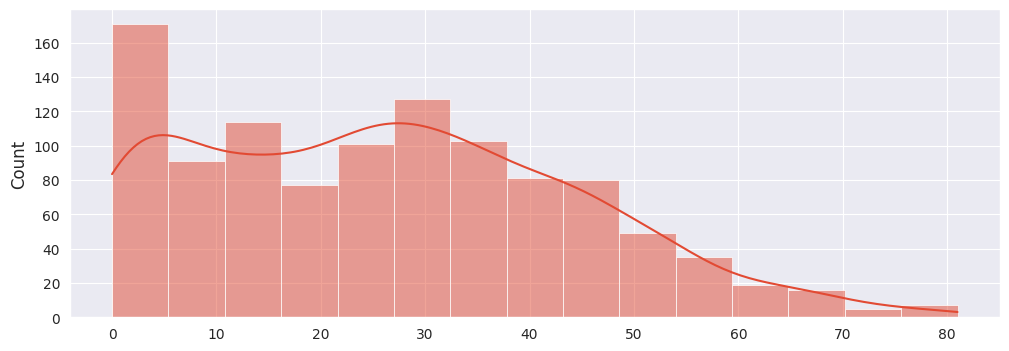

In [7]:
fig, ax = plt.subplots(figsize=(12,4))
sns.histplot(y_test.values, kde=True)

## Some Preprocessing 

In [9]:
base_w = 1 / pd.Series(y).value_counts() / y.shape[0] * 10000
base_w = base_w.to_dict()
sample_weight_gs = np.array([np.round(base_w[x], 2) for x in y]) + 10

base_w = 1 / pd.Series(y_train).value_counts() / y_train.shape[0] * 10000
base_w = base_w.to_dict()
sample_weight = np.array([np.round(base_w[x], 2) for x in y_train]) + 10

In [84]:
len(y_train[y_train>60])

169

# ML Models 

In [81]:
dr = DummyRegressor(strategy="median")
dr.fit(X_audio_train, y_train)
preds = dr.predict(X_audio_test).round(0)
preds = pd.Series(preds, index=y_test)

dr_audio_mae, dr_audio_mse, dr_audio_sp, dr_audio_r2 = report(dr, X_audio_train)

MAE: 15.007434944237918
MSE: 330.41449814126395
Spearman's Correlation -0.049796951417597796
R Squared:-0.0033850673101643025


In [30]:
dr = DummyRegressor(strategy="mean")
dr.fit(X_genres_train, y_train)
preds = dr.predict(X_genres_test).round(0)
preds = pd.Series(preds, index=y_test)

dr_genres_mae, dr_genres_mse, dr_genres_sp, dr_genres_r2 = report(dr, X_genres_train)

MAE: 15.00557620817844
MSE: 328.90520446096656
Spearman's Correlation -0.049796951417597796
R Squared:0.0


In [35]:
dr = DummyRegressor(strategy="mean")
dr.fit(X_audio_train, y_train)
preds = dr.predict(X_audio_test).round(0)
preds = pd.Series(preds, index=y_test)

dr_mel_features_mae,dr_mel_features_mse,dr_mel_features_sp,dr_mel_features_r2=report(
    dr, X_mel_features_train)

MAE: 15.00557620817844
MSE: 328.90520446096656
Spearman's Correlation -0.049796951417597796
R Squared:0.0


In [36]:
dr = DummyRegressor(strategy="mean")
dr.fit(X_audio_train, y_train)
preds = dr.predict(X_audio_test).round(0)
preds = pd.Series(preds, index=y_test)

dr_before_mae, dr_before_mse, dr_before_sp, dr_before_r2 = report(
    dr, X_before_train)

MAE: 15.00557620817844
MSE: 328.90520446096656
Spearman's Correlation -0.049796951417597796
R Squared:0.0


In [37]:
dr = DummyRegressor(strategy="mean")
dr.fit(X_static_views_train, y_train)
preds = dr.predict(X_static_views_test).round(0)
preds = pd.Series(preds, index=y_test)

dr_static_views_mae, dr_static_views_mse, dr_static_views_sp, dr_static_views_r2 = report(dr, X_static_views_train)

MAE: 15.00557620817844
MSE: 328.90520446096656
Spearman's Correlation -0.049796951417597796
R Squared:0.0


In [38]:
dr = DummyRegressor(strategy="mean")
dr.fit(X_after_train, y_train)
preds = dr.predict(X_after_test).round(0)
preds = pd.Series(preds, index=y_test)

dr_after_mae, dr_after_mse, dr_after_sp, dr_after_r2 = report(dr, X_after_train)

MAE: 15.00557620817844
MSE: 328.90520446096656
Spearman's Correlation -0.049796951417597796
R Squared:0.0


## KNN 

In [26]:
knn = KNeighborsRegressor(n_neighbors=15, metric='cosine')
knn.fit(X_audio_train, y_train)
preds = knn.predict(X_audio_test).round(0)
preds = pd.Series(preds, index=y_test)

knn_audio_mae, knn_audio_mse, knn_audio_sp, knn_audio_r2 = report(knn, X_audio_train, preds)

MAE: 14.883828996282528
MSE: 326.28903345724905
Spearman's Correlation 0.1741123785777087
R Squared:0.1344290221007105


In [45]:
knn = KNeighborsRegressor(n_neighbors=35, metric='cosine')
knn.fit(X_genres_train, y_train)
preds = knn.predict(X_genres_test).round(0)
preds = pd.Series(preds, index=y_test)

knn_genres_mae, knn_genres_mse, knn_genres_sp = report(preds, y_test)

MAE: 14.285315985130111
MSE: 307.4191449814126
Spearman's Correlation 0.24446777681103646


In [71]:
knn = KNeighborsRegressor(n_neighbors=200, metric='cosine')
knn.fit(X_mel_features_train, y_train)
preds = knn.predict(X_mel_features_test).round(0)
preds = pd.Series(preds, index=y_test)

knn_mel_features_mae, knn_mel_features_mse, knn_mel_features_sp = report(preds, y_test)

MAE: 14.878252788104088
MSE: 324.72955390334573
Spearman's Correlation 0.10421228579141555


In [77]:
knn = KNeighborsRegressor(n_neighbors=40, metric='cosine')
knn.fit(X_before_train, y_train)
preds = knn.predict(X_before_test).round(0)
preds = pd.Series(preds, index=y_test)

knn_before_mae, knn_before_mse, knn_before_sp = report(preds, y_test)

MAE: 14.236059479553903
MSE: 297.2620817843866
Spearman's Correlation 0.3163615828623981


In [83]:
knn = KNeighborsRegressor(n_neighbors=20, metric='cosine')
knn.fit(X_static_views_train, y_train)
preds = knn.predict(X_static_views_test).round(0)
preds = pd.Series(preds, index=y_test)

knn_static_views_mae, knn_static_views_mse, knn_static_views_sp = report(preds, y_test)

MAE: 10.319702602230484
MSE: 180.00371747211895
Spearman's Correlation 0.6614276566728948


In [92]:
knn = KNeighborsRegressor(n_neighbors=40, metric='cosine')
knn.fit(X_after_train, y_train)
preds = knn.predict(X_after_test).round(0)
preds = pd.Series(preds, index=y_test)

knn_after_mae, knn_after_mse, knn_after_sp = report(preds, y_test)

MAE: 14.067843866171003
MSE: 288.2685873605948
Spearman's Correlation 0.3359082954510153


## Random Forest

### Spotify Tags

In [48]:
rf = RandomForestRegressor(n_estimators=400, max_features=5, n_jobs=-1, random_state=123)
rf.fit(X_audio_train, y_train, sample_weight=sample_weight)
preds = rf.predict(X_audio_test).round(0)
preds = pd.Series(preds, index=y_test)

rf_audio_mae, rf_audio_mse, rf_audio_sp, rf_audio_r2 = report(rf, X_audio_train)

MAE: 14.631040892193308
MSE: 312.2555762081784
Spearman's Correlation 0.222557747005276
R Squared:0.8820387979138498


### Genres

In [44]:
rf = RandomForestRegressor(n_estimators=10, max_features=10, n_jobs=-1, random_state=123)
rf.fit(X_genres_train, y_train, sample_weight)
preds = rf.predict(X_genres_test).round(0)
preds = pd.Series(preds, index=y_test)

rf_genres_mae, rf_genres_mse, rf_genres_sp, rf_genres_r2 = report(rf, X_genres_train)

MAE: 14.139405204460967
MSE: 304.07620817843866
Spearman's Correlation 0.2897158254211325
R Squared:0.08220055422133699


### MFCCs 

In [49]:
rf = RandomForestRegressor(n_estimators=1000, max_features=15, n_jobs=-1, random_state=123)
rf.fit(X_mel_features_train, y_train, sample_weight)
preds = rf.predict(X_mel_features_test).round(0)
preds = pd.Series(preds, index=y_test)

rf_mel_features_mae, rf_mel_features_mse, rf_mel_features_sp, rf_mel_features_r2 = report(rf, X_mel_features_train)

MAE: 14.79275092936803
MSE: 319.83921933085503
Spearman's Correlation 0.1569016458068085
R Squared:0.8682998160928204


### (T) Spotify Tags + Genres + MFCCs

In [50]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100],
    'max_features': [5, 10, 15],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [6, 8, 10],
    'n_estimators': [300, 500, 1000, 2000]
}

# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1 if x in X_before_train.index else 0 for x in X_before.index]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = RandomForestRegressor(random_state=123), param_grid = param_grid, 
                              cv = pds, n_jobs = -1, verbose=2)
# Fit the grid search to the data
fit_params={'sample_weight': sample_weight_gs}
grid_search.fit(X_before, y, **fit_params)
grid_search.best_estimator_

Fitting 1 folds for each of 324 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   5.5s
[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=500; total time=   8.0s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=2, min_samples_split=6, n_estimators=2000; total time= 1.1min


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   5.2s
[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  16.1s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=6, n_estimators=500; total time=  15.5s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=8, n_estimators=500; total time=  14.6s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=2, min_samples_split=8, n_estimators=2000; total time= 1.4min
[CV] END bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=2, min_samples_split=6, n_estimators=2000; total time= 1.1min
[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=2, min_samples_split=8, n_estimators=500; total time=   9.1s
[CV] END bootstrap=True, max_depth=80, max_features=5, min_sam

RandomForestRegressor(max_depth=80, max_features=15, min_samples_leaf=2,
                      min_samples_split=10, n_estimators=300, random_state=123)

In [51]:
rf = RandomForestRegressor(**grid_search.best_params_, n_jobs=-1, random_state=123)
rf.fit(X_before_train, y_train, sample_weight)
preds = rf.predict(X_before_test).round(0)
preds = pd.Series(preds, index=y_test)

rf_before_mae, rf_before_mse, rf_before_sp, rf_before_r2 = report(rf, X_before_train)

MAE: 14.28903345724907
MSE: 297.0938661710037
Spearman's Correlation 0.3197471338716206
R Squared:0.7171858399657096


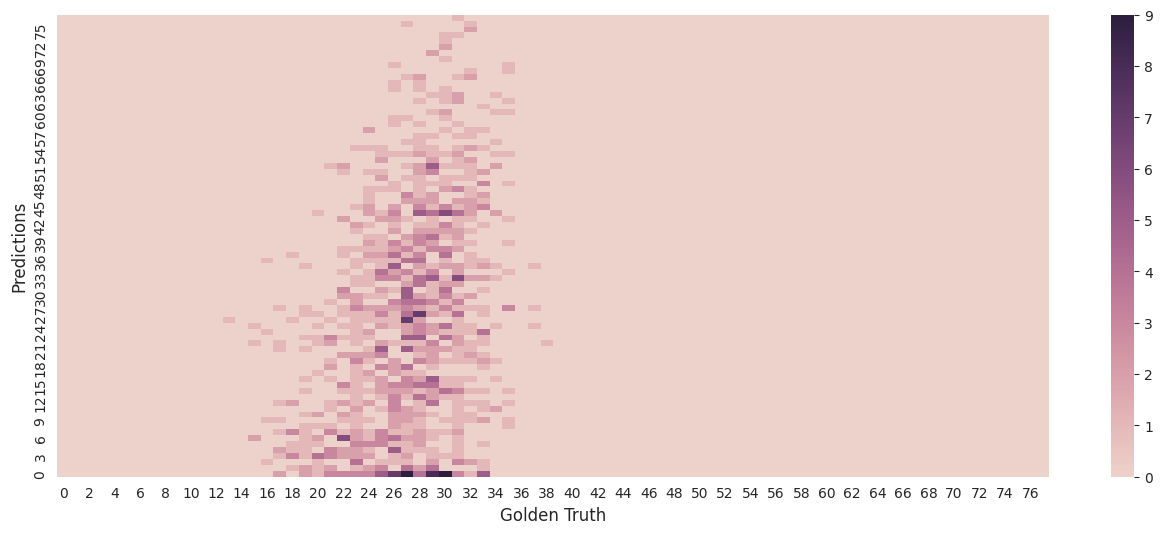

In [98]:
results = pd.DataFrame([y_test.values, preds], index=['actual', 'predicted']).T.round(0).astype(int)

ax= sns.heatmap(confusion_matrix(results.actual, results.predicted), cmap=sns.cubehelix_palette(as_cmap=True));
ax.set(xlabel='Golden Truth', ylabel='Predictions');
plt.ylim(reversed(plt.ylim()));
plt.yticks(rotation=90);

### YouTube Views 

In [52]:
rf = RandomForestRegressor(n_estimators=1000, max_features=10, n_jobs=-1, random_state=123)
rf.fit(X_static_views_train, y_train, sample_weight)
preds = rf.predict(X_static_views_test).round(0)
preds = pd.Series(preds, index=y_test)

rf_static_views_mae, rf_static_views_mse, rf_static_views_sp, rf_static_views_r2 = report(rf, X_static_views_train)

MAE: 9.803903345724907
MSE: 171.53624535315984
Spearman's Correlation 0.6742004256176862
R Squared:0.9485579486917683


### (T) Spotify Tags + Genres + MFCC's + YouTube Views 

In [53]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100],
    'max_features': [5, 10, 15],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [6, 8, 10],
    'n_estimators': [300, 500, 1000, 2000]
}

# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1 if x in X_after_train.index else 0 for x in X_after.index]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = RandomForestRegressor(random_state=123), param_grid = param_grid, 
                              cv = pds, n_jobs = -1, verbose=2)
# Fit the grid search to the data
fit_params={'sample_weight': sample_weight_gs}
grid_search.fit(X_after, y, **fit_params)
grid_search.best_estimator_

Fitting 1 folds for each of 324 candidates, totalling 324 fits
[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   8.4s
[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  15.9s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=6, n_estimators=2000; total time= 1.0min
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=4, min_samples_split=6, n_estimators=2000; total time= 1.4min
[CV] END bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=4, min_samples_split=8, n_estimators=2000; total time=  58.2s
[CV] END bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  18.1s
[CV] END bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  1

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   5.0s
[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=   4.8s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   9.6s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   9.3s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=8, n_estimators=2000; total time= 1.0min
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  41.1s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=1000; total time=  15.7s
[CV] END bootstrap=True, max_depth=90, max_features=10, min_s

RandomForestRegressor(max_depth=80, max_features=15, min_samples_leaf=2,
                      min_samples_split=6, n_estimators=2000, random_state=123)

In [54]:
rf = RandomForestRegressor(**grid_search.best_params_, n_jobs=-1, random_state=123)
rf.fit(X_after_train, y_train, sample_weight)
preds = rf.predict(X_after_test).round(0)
preds = pd.Series(preds, index=y_test)

rf_after_mae, rf_after_mse, rf_after_sp, rf_after_r2 = report(rf, X_after_train)

MAE: 9.525092936802974
MSE: 162.0604089219331
Spearman's Correlation 0.6974272164617765
R Squared:0.9128282568689771
[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  18.3s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time= 1.0min
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=3, min_samples_split=10, n_estimators=2000; total time= 1.4min
[CV] END bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=4, min_samples_split=6, n_estimators=500; total time=  14.5s
[CV] END bootstrap=True, max_depth=90, max_features=15, min_samples_leaf=2, min_samples_split=8, n_estimators=300; total time=  12.9s
[CV] END bootstrap=True, max_depth=90, max_features=15, min_samples_leaf=3, min_samples_split=6, n_estimators=500; total time=  21.3s
[CV] END bootstrap=True, max_depth=90, max_features=15, min_samples_leaf=4,

[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=2000; total time=  33.8s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=10, n_estimators=2000; total time=  59.1s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  20.0s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=6, n_estimators=2000; total time=  34.2s
[CV] END bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=   9.4s
[CV] END bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=3, min_samples_split=10, n_estimators=500; total time=  14.9s
[CV] END bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time=  57.2s
[CV] END bootstrap=True, max_depth=100, max_features=5, 

[CV] END bootstrap=True, max_depth=90, max_features=15, min_samples_leaf=3, min_samples_split=10, n_estimators=500; total time=  20.5s
[CV] END bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   5.4s
[CV] END bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  18.1s
[CV] END bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   5.0s
[CV] END bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=6, n_estimators=500; total time=   8.0s
[CV] END bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=2000; total time=  32.1s
[CV] END bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=4, min_samples_split=8, n_estimators=500; total time=  14.6s
[CV] END bootstrap=True, max_depth=100, max_features=15, 

[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  16.9s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=2, min_samples_split=8, n_estimators=2000; total time= 1.0min
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=4, min_samples_split=6, n_estimators=500; total time=  20.5s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=2, min_samples_split=8, n_estimators=300; total time=   5.4s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   5.2s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=6, n_estimators=500; total time=   8.6s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=2000; total time=  33.3s
[CV] END bootstrap=True, max_depth=90, max_features=10, min_sam

[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=6, n_estimators=500; total time=   8.7s
[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   4.8s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=2, min_samples_split=8, n_estimators=300; total time=   9.4s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  31.1s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  12.7s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=3, min_samples_split=6, n_estimators=2000; total time= 1.4min
[CV] END bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=  15.0s
[CV] END bootstrap=True, max_depth=90, max_features=10, min_

[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=2, min_samples_split=8, n_estimators=300; total time=   5.4s
[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=   4.8s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=  16.0s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=  15.0s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  28.4s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  41.6s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  17.0s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_sa

[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=  35.3s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  29.2s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  42.8s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=   8.6s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=   8.2s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=2000; total time=  32.7s
[CV] END bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  29.4s
[CV] END bootstrap=True, max_depth=90, max_features=15, m

[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=500; total time=   8.5s
[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=2000; total time=  32.4s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   8.6s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  43.6s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  40.4s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=   7.8s
[CV] END bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=2, min_samples_split=8, n_estimators=2000; total time= 1.0min
[CV] END bootstrap=True, max_depth=90, max_features=15, m

[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  18.1s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  30.6s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=2, min_samples_split=8, n_estimators=300; total time=  13.0s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=  12.8s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=  12.3s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=  12.3s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  18.6s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_

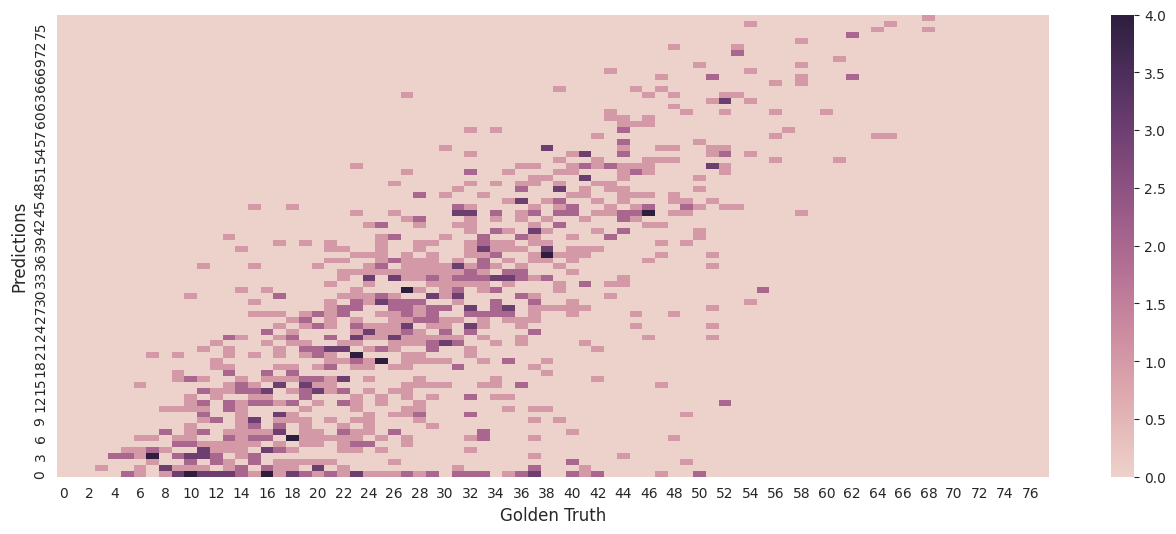

[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=2, min_samples_split=8, n_estimators=300; total time=   5.4s
[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=   4.7s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=2, min_samples_split=6, n_estimators=500; total time=  15.9s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=8, n_estimators=500; total time=  14.8s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=  28.2s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  41.7s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  16.8s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_sa

[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=2, min_samples_split=8, n_estimators=2000; total time=  35.7s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=6, n_estimators=2000; total time=  57.3s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=4, min_samples_split=10, n_estimators=2000; total time= 1.3min
[CV] END bootstrap=True, max_depth=90, max_features=15, min_samples_leaf=2, min_samples_split=6, n_estimators=2000; total time= 1.5min
[CV] END bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   9.4s
[CV] END bootstrap=True, max_depth=100, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  29.9s
[CV] END bootstrap=True, max_depth=100, max_features=15, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  42.4s
[CV] END bootstrap=True, max_depth=100, max_features

[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  18.1s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=  59.9s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=3, min_samples_split=10, n_estimators=2000; total time= 1.4min
[CV] END bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  28.4s
[CV] END bootstrap=True, max_depth=90, max_features=15, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  42.0s
[CV] END bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   5.1s
[CV] END bootstrap=True, max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=6, n_estimators=500; total time=   8.4s
[CV] END bootstrap=True, max_depth=100, max_features=5,

[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  16.4s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=2, min_samples_split=8, n_estimators=500; total time=  15.3s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   8.7s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=10, n_estimators=500; total time=  14.1s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=2, min_samples_split=10, n_estimators=500; total time=  21.1s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=3, min_samples_split=10, n_estimators=500; total time=  20.4s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   5.4s
[CV] END bootstrap=True, max_depth=90, max_features=5, min

[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  18.1s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  30.2s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=2, min_samples_split=8, n_estimators=300; total time=  12.9s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=3, min_samples_split=6, n_estimators=300; total time=  12.7s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=  12.1s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=4, min_samples_split=8, n_estimators=300; total time=  12.1s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=2, min_samples_split=6, n_estimators=1000; total time=  17.8s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_

[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=  34.8s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  29.3s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  42.7s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  17.3s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  15.6s
[CV] END bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=2, min_samples_split=8, n_estimators=1000; total time=  30.9s
[CV] END bootstrap=True, max_depth=90, max_features=15, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=  13.2s
[CV] END bootstrap=True, max_depth=90, max_features=15, m

[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=2000; total time=  32.5s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=10, n_estimators=1000; total time=  29.0s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=3, min_samples_split=6, n_estimators=500; total time=  21.1s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=4, min_samples_split=6, n_estimators=1000; total time=  40.4s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=6, n_estimators=500; total time=   7.8s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=2000; total time=  31.3s
[CV] END bootstrap=True, max_depth=90, max_features=10, min_samples_leaf=4, min_samples_split=8, n_estimators=500; total time=  14.4s
[CV] END bootstrap=True, max_depth=90, max_features=15, min

[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=2, min_samples_split=6, n_estimators=300; total time=   5.5s
[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=4, min_samples_split=8, n_estimators=500; total time=   7.9s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=2, min_samples_split=8, n_estimators=300; total time=   9.2s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=3, min_samples_split=6, n_estimators=1000; total time=  30.7s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=  12.5s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=  12.4s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=4, min_samples_split=6, n_estimators=300; total time=  12.0s
[CV] END bootstrap=True, max_depth=80, max_features=15, min_sa

[CV] END bootstrap=True, max_depth=80, max_features=5, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=  16.8s
[CV] END bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=2, min_samples_split=8, n_estimators=2000; total time= 1.0min
[CV] END bootstrap=True, max_depth=80, max_features=15, min_samples_leaf=4, min_samples_split=6, n_estimators=500; total time=  20.2s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=2, min_samples_split=8, n_estimators=300; total time=   5.3s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   5.2s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=6, n_estimators=500; total time=   8.5s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samples_leaf=3, min_samples_split=10, n_estimators=300; total time=   4.9s
[CV] END bootstrap=True, max_depth=90, max_features=5, min_samp

In [102]:
results = pd.DataFrame([y_test.values, preds], index=['actual', 'predicted']).T.round(0).astype(int)

ax= sns.heatmap(confusion_matrix(results.actual, results.predicted), cmap=sns.cubehelix_palette(as_cmap=True))
ax.set(xlabel='Golden Truth', ylabel='Predictions');
plt.ylim(reversed(plt.ylim()));
plt.yticks(rotation=90);

### Results 

In [70]:
#Random Forest
pd.DataFrame(
    [[rf_audio_mae, rf_audio_mse, rf_audio_sp[0]], [rf_genres_mae, rf_genres_mse, rf_genres_sp[0]], [rf_mel_features_mae, rf_mel_features_mse, rf_mel_features_sp[0]], [rf_before_mae, rf_before_mse, rf_before_sp[0]],
    [rf_static_views_mae, rf_static_views_mse, rf_static_views_sp[0]], [rf_after_mae, rf_after_mse, rf_after_sp[0]]],
    columns=['MAE', 'MSE', "Spearman's Correlation"],
    index=["Spotify Tags", "Genres", "MFCC's", "Spotify Tags + Genres + MFCC's", "YouTube Views", "Spotify Tags + Genres + MFCC's + YouTube Views"],
)

,MAE,MSE,Spearman's Correlation
Spotify Tags,14.621747,311.699814,0.225711
Genres,14.131041,304.456320,0.288563
MFCC's,14.792751,319.839219,0.156902
Spotify Tags + Genres + MFCC's,14.289033,297.093866,0.319747
YouTube Views,9.829926,173.002788,0.672435
Spotify Tags + Genres + MFCC's + YouTube Views,9.551115,162.718401,0.697883


## LightGBM 

### Spotify Tags

In [58]:
lgb = LGBMRegressor(n_estimators=100, num_leaves=20, n_jobs=-1, random_state=123)
lgb.fit(X_audio_train, y_train, sample_weight)
preds = lgb.predict(X_audio_test).round(0)
preds = pd.Series(preds, index=y_test)

lgb_audio_mae, lgb_audio_mse, lgb_audio_sp, lgb_audio_r2 = report(lgb, X_audio_train)

MAE: 14.630111524163569
MSE: 313.4888475836431
Spearman's Correlation 0.2248047983975159
R Squared:0.3134929245613849


### Genres

In [59]:
lgb = LGBMRegressor(n_estimators=150, num_leaves=10, n_jobs=-1, random_state=123)
lgb.fit(X_genres_train, y_train, sample_weight)
preds = lgb.predict(X_genres_test).round(0)
preds = pd.Series(preds, index=y_test)

lgb_genres_mae, lgb_genres_mse, lgb_genres_sp, lgb_genres_r2 = report(lgb, X_genres_train)

MAE: 14.131040892193308
MSE: 298.94516728624535
Spearman's Correlation 0.2883988428323491
R Squared:0.06573167623930398


### MFCC's 

In [60]:
lgb = LGBMRegressor(n_estimators=100, num_leaves=10, n_jobs=-1, random_state=123)
lgb.fit(X_mel_features_train, y_train)
preds = lgb.predict(X_mel_features_test).round(0)
preds = pd.Series(preds, index=y_test)

lgb_mel_features_mae, lgb_mel_features_mse, lgb_mel_features_sp, lgb_mel_features_r2 = report(lgb, X_mel_features_train)

MAE: 14.820631970260223
MSE: 321.1514869888476
Spearman's Correlation 0.14435705456378278
R Squared:0.18959412438561685


### (T) Spotify Tags + Genres + MFCCs 

In [181]:
# Create the parameter grid based on the results of random search 
param_grid = {
     'boosting': ['gbdt' ],
     'objective': ['mean_absolute_error'],
     'num_iterations': [  1500, 2000,5000  ],
     'learning_rate':[  0.05, 0.005 ],
     'num_leaves':[ 7, 10, 15, 25],
     'max_depth' :[ 10,15,25],
     'min_data_in_leaf':[15,25 ],
     #'feature_fraction': [0.5, 0.6, 0.8],
     #'bagging_fraction': [0.6, 0.8],
     #'bagging_freq': [50, 100, 200],
}

# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1 if x in X_before_train.index else 0 for x in X_before.index]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = LGBMRegressor(random_state=123), param_grid = param_grid, 
                              cv = pds, n_jobs = -1, verbose=0)
# Fit the grid search to the data
fit_params={'sample_weight': sample_weight_gs}
grid_search.fit(X_before, y, **fit_params)
grid_search.best_estimator_

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


LGBMRegressor(boosting='gbdt', learning_rate=0.005, max_depth=15,
              min_data_in_leaf=15, num_iterations=1500, num_leaves=15,
              objective='mean_absolute_error', random_state=123)

In [182]:
lgb = LGBMRegressor(**grid_search.best_params_, n_jobs=-1, random_state=123)
lgb.fit(X_before_train, y_train, sample_weight)
preds = lgb.predict(X_before_test).round(0)
preds = pd.Series(preds, index=y_test)

lgb_before_mae, lgb_before_mse, lgb_before_sp, lgb_before_r2 = report(lgb, X_before_train)

MAE: 13.893122676579926
MSE: 288.17379182156134
Spearman's Correlation 0.34360239592366426
R Squared:0.25831454678564325


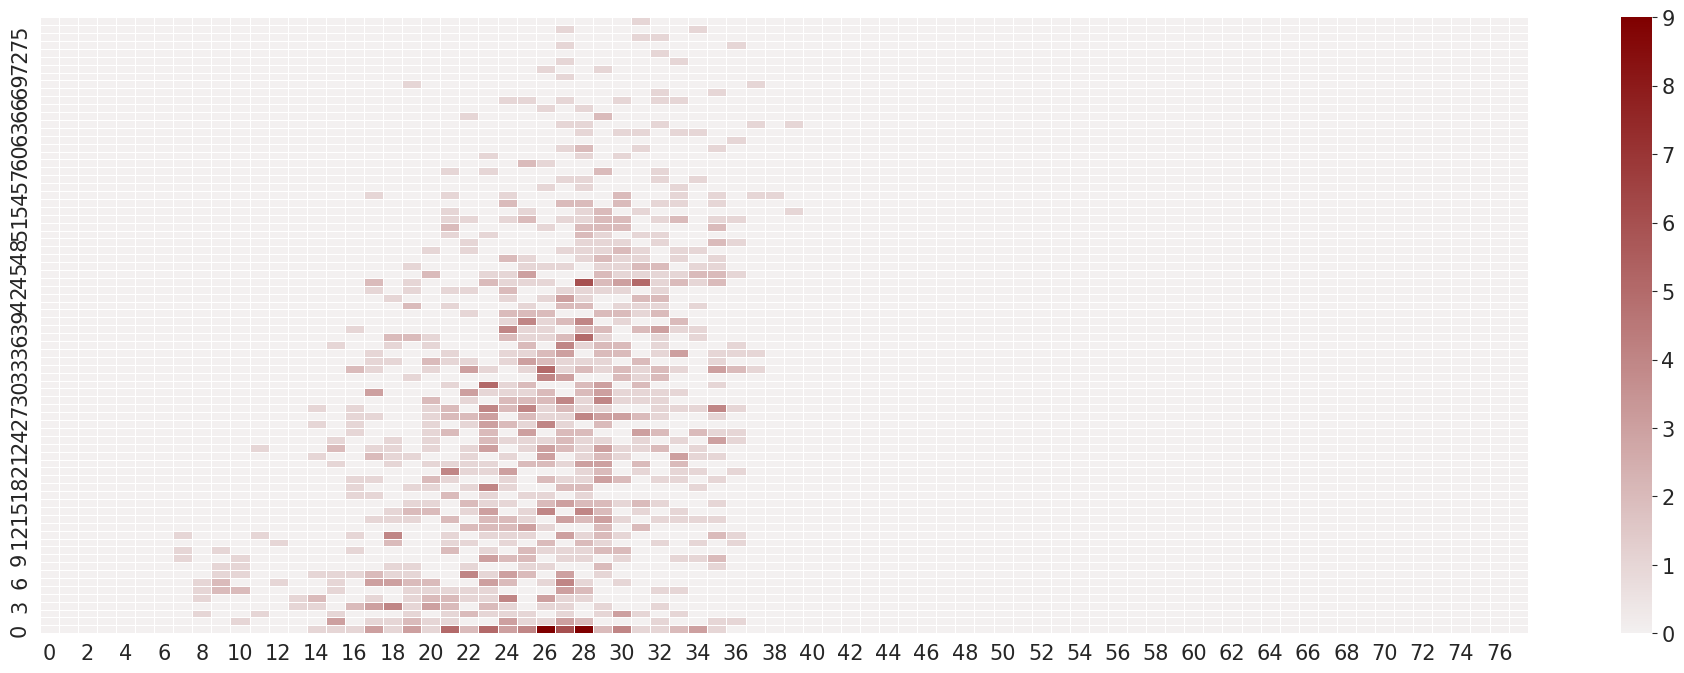

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

In [183]:
plt.rcParams.update({'font.size': 15})
sns.set_style("whitegrid")
plt.figure(figsize=(24, 8))
results = pd.DataFrame([y_test.values, preds], index=['actual', 'predicted']).T.round(0).astype(int)

ax= sns.heatmap(confusion_matrix(results.actual, results.predicted), cmap=sns.color_palette("light:maroon", as_cmap=True), linewidths=.5)
ax.set(xlabel='', ylabel='');
plt.ylim(reversed(plt.ylim()));
plt.yticks(rotation=90);

<AxesSubplot: >

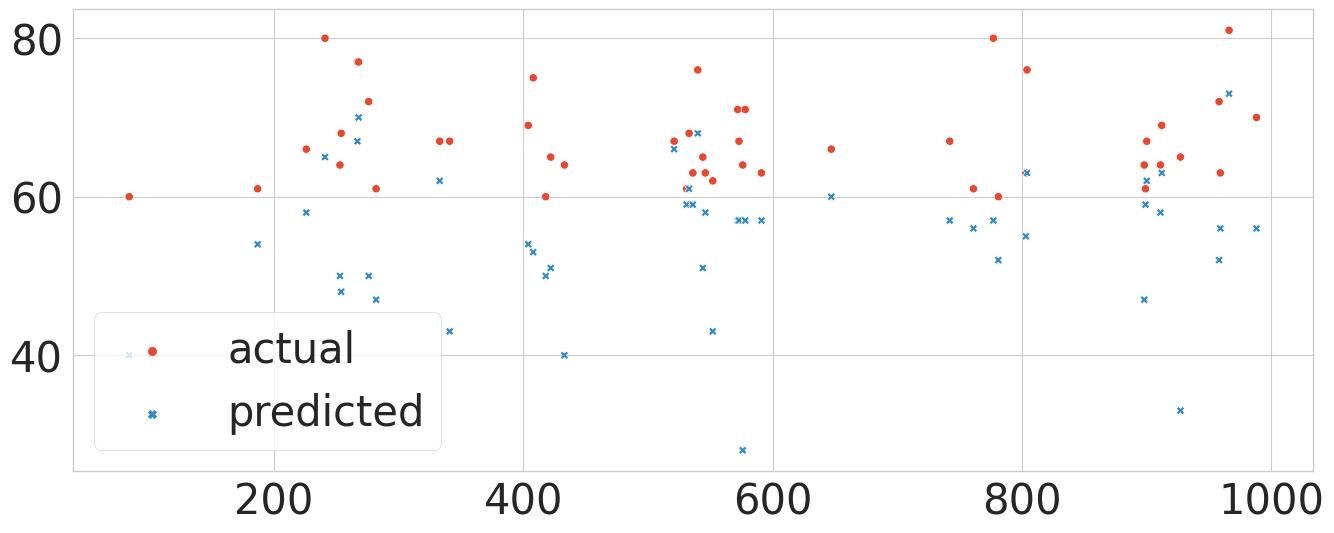

In [125]:
sns.scatterplot(results[results.actual>59])

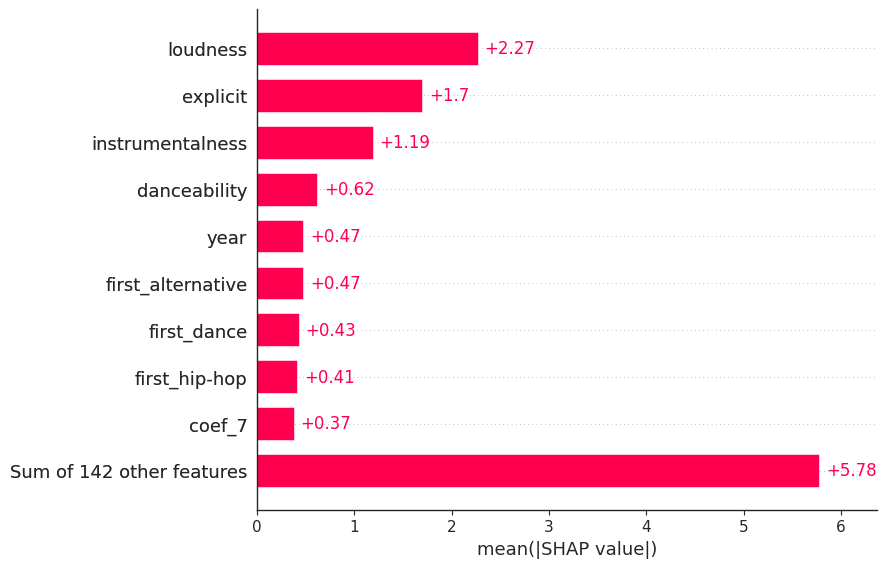

In [76]:
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (16, 6)

explainer = shap.Explainer(lgb)
shap_values = explainer(X_before_train)
shap.plots.bar(shap_values)

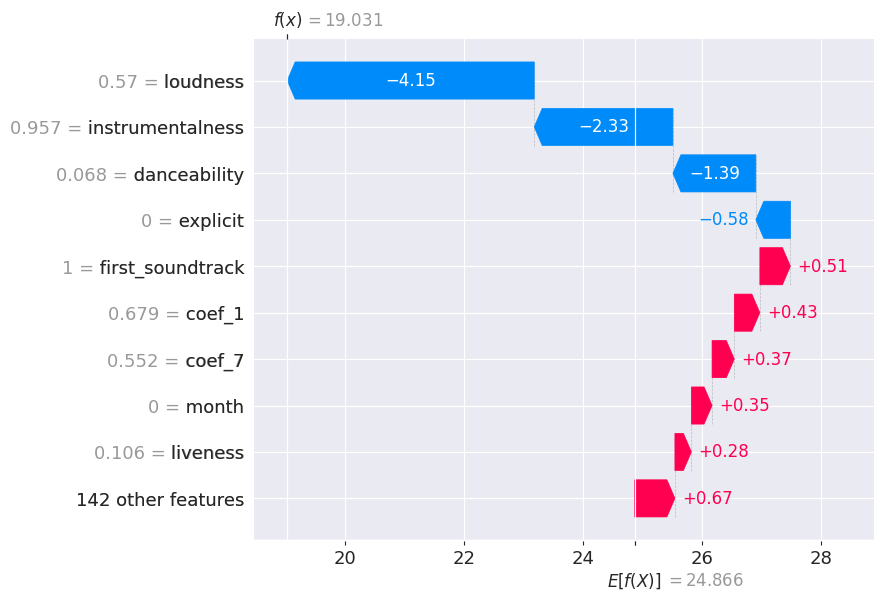

In [65]:
shap.plots.waterfall(shap_values[399]) #for one song

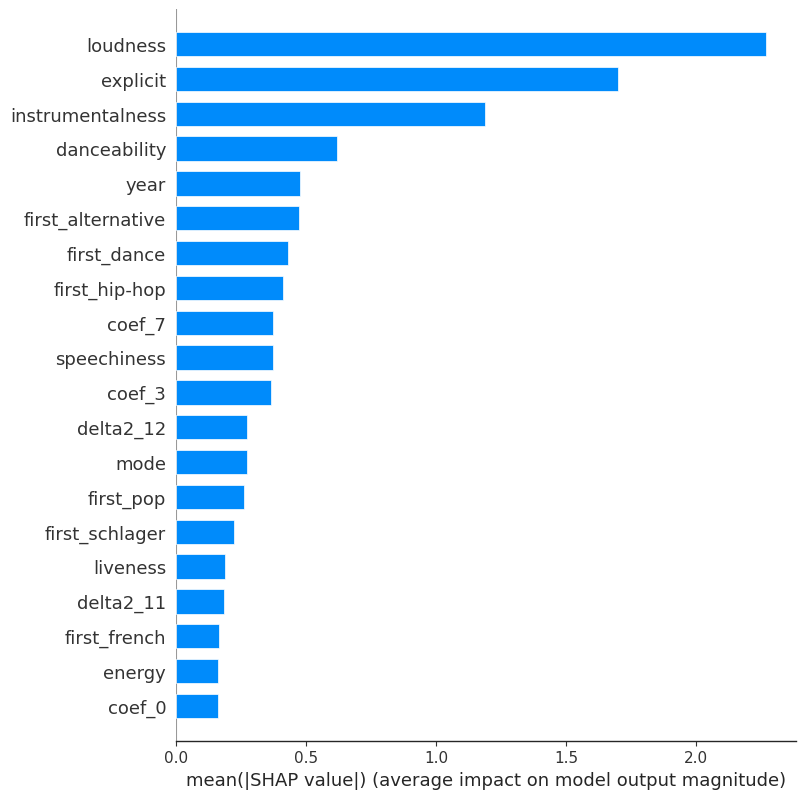

In [77]:
shap.summary_plot(shap_values, X_before_train, plot_type="bar")

### YouTube Views

In [64]:
lgb = LGBMRegressor(n_estimators=100, num_leaves=15, n_jobs=-1, random_state=123)
lgb.fit(X_static_views_train, y_train, sample_weight)
preds = lgb.predict(X_static_views_test).round(0)
preds = pd.Series(preds, index=y_test)

lgb_static_views_mae, lgb_static_views_mse, lgb_static_views_sp, lgb_static_views_r2 = report(lgb, X_static_views_train)

MAE: 9.821561338289962
MSE: 172.05018587360595
Spearman's Correlation 0.6768474430067478
R Squared:0.6853708668015921


### (T) Spotify Tags + Genres + MFCC's + YouTube Views 

In [165]:
# Create the parameter grid based on the results of random search 
param_grid = {
     'boosting': ['gbdt' ],
     'objective': ['mean_absolute_error'],
     'num_iterations': [  1500, 2000,5000  ],
     'learning_rate':[  0.05, 0.005 ],
     'num_leaves':[ 7, 10, 15, 25],
     'max_depth' :[ 10,15,25],
     'min_data_in_leaf':[15,25 ],
     #'feature_fraction': [0.5, 0.6, 0.8],
     #'bagging_fraction': [0.6, 0.8],
     #'bagging_freq': [50, 100, 200],
}

# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1 if x in X_after_train.index else 0 for x in X_after.index]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = LGBMRegressor(random_state=123), param_grid = param_grid, 
                              cv = pds, n_jobs = -1, verbose=0)
# Fit the grid search to the data
fit_params={'sample_weight': sample_weight_gs}
grid_search.fit(X_after, y, **fit_params)
grid_search.best_estimator_

Found `num_iterations` in params. Will use it instead of argument


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25


LGBMRegressor(boosting='gbdt', learning_rate=0.005, max_depth=10,
              min_data_in_leaf=25, num_iterations=5000, num_leaves=15,
              objective='mean_absolute_error', random_state=123)

In [166]:
lgb = LGBMRegressor(**grid_search.best_params_, n_jobs=-1, random_state=123)
lgb.fit(X_after_train, y_train)
preds = lgb.predict(X_after_test).round(0)
preds = pd.Series(preds, index=y_test)

lgb_after_mae, lgb_after_mse, lgb_after_sp, lgb_after_r2 = report(lgb, X_after_train)

MAE: 9.110594795539033
MSE: 156.4488847583643
Spearman's Correlation 0.7100518452142572
R Squared:0.7506402955463255


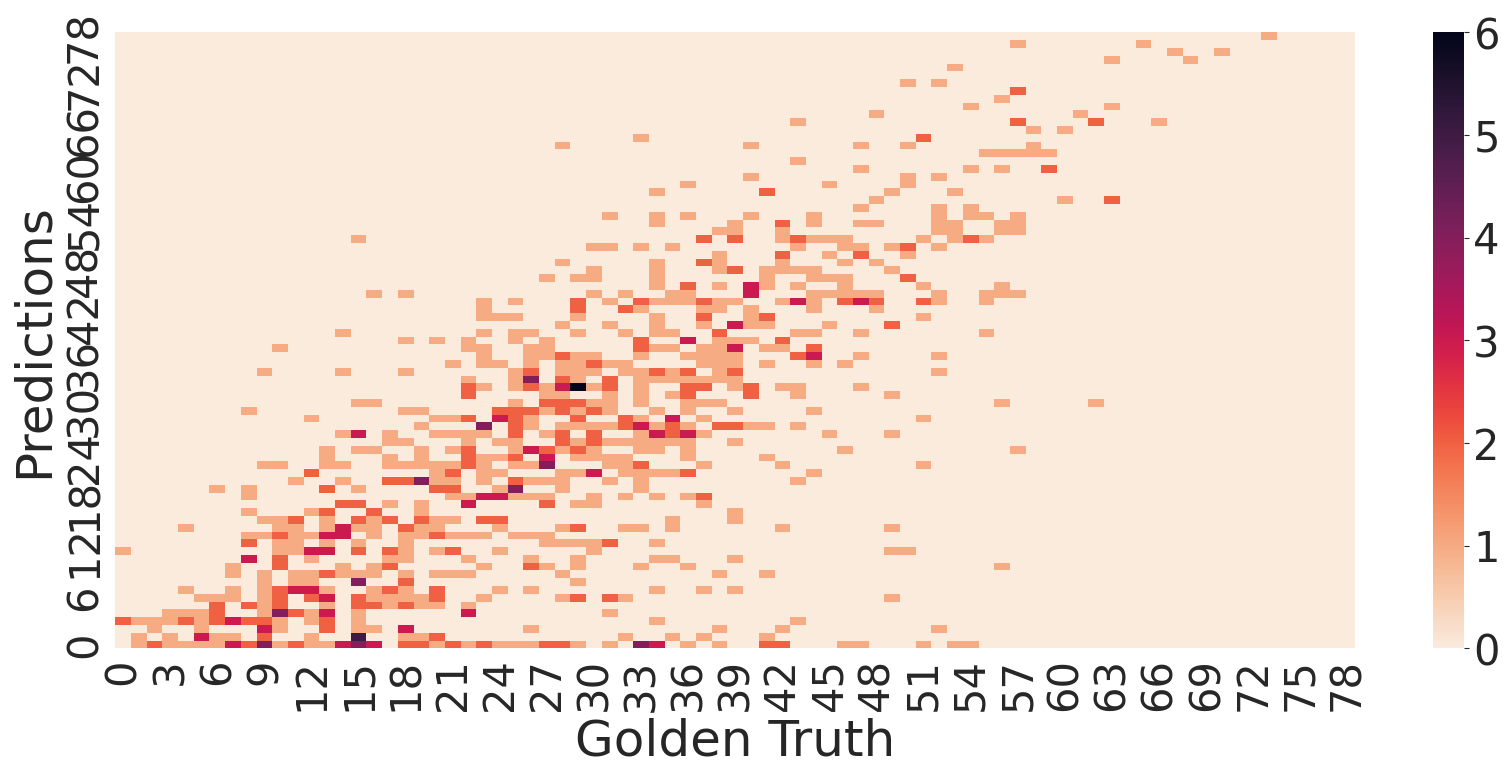

In [167]:
plt.rcParams.update({'font.size': 30})
sns.set_style("whitegrid")
plt.figure(figsize=(20, 8))

results = pd.DataFrame([y_test.values, preds], index=['actual', 'predicted']).T.round(0).astype(int)

ax= sns.heatmap(confusion_matrix(results.actual, results.predicted), cmap=sns.color_palette("light:maroon", as_cmap=True), linewidths=.5, yticklabels=False)
ax.set(xlabel='Golden Truth', ylabel='');
plt.ylim(reversed(plt.ylim()));
plt.yticks(rotation=90);

In [93]:
results

,actual,predicted
0,26,24
1,52,33
2,28,25
3,46,27
4,37,28
...,...,...
1071,0,28
1072,2,30
1073,0,28
1074,2,33


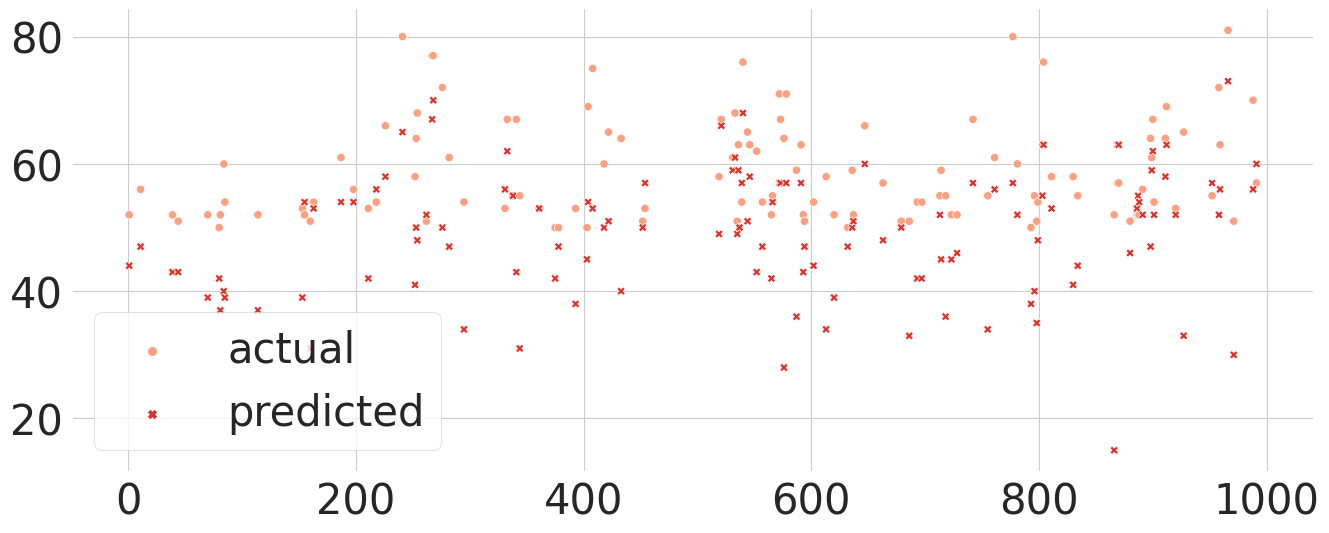

In [142]:
sns.set_style('whitegrid')
sns.scatterplot(results[results.actual > 49], palette='Reds', alpha =1)
sns.despine(bottom=True, left=True)

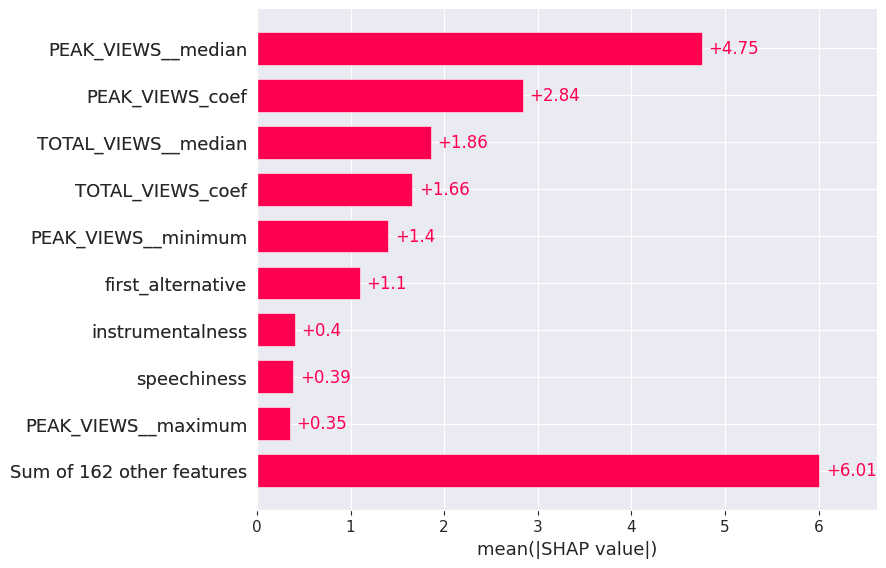

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15


/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

In [81]:
explainer = shap.Explainer(lgb)
shap_values = explainer(X_after_train)
shap.plots.bar(shap_values)

### Results 

In [122]:
#LighGBM
pd.DataFrame(
    [[lgb_audio_mae,lgb_audio_mse, lgb_audio_sp[0]], [lgb_genres_mae, lgb_genres_mse, lgb_genres_sp[0]], [lgb_mel_features_mae, lgb_mel_features_mse, lgb_mel_features_sp[0]], [lgb_before_mae, lgb_before_mse, lgb_before_sp[0]],
    [lgb_static_views_mae, lgb_static_views_mse, lgb_static_views_sp[0]], [lgb_after_mae, lgb_after_mse, lgb_after_sp[0]]],
    columns=['MAE', 'MSE', "Spearman's Correlation"],
    index=["Spotify Tags", "Genres", "MFCC's", "Spotify Tags + Genres + MFCC's", "YouTube Views", "Spotify Tags + Genres + MFCC's + YouTube Views"],
)

,MAE,MSE,Spearman's Correlation
Spotify Tags,14.630112,313.488848,0.224805
Genres,14.131041,298.945167,0.288399
MFCC's,14.820632,321.151487,0.144357
Spotify Tags + Genres + MFCC's,13.893123,288.173792,0.343602
YouTube Views,9.821561,172.050186,0.676847
Spotify Tags + Genres + MFCC's + YouTube Views,9.110595,156.448885,0.710052


[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

## XGBoost 

### Spotify Tags

In [9]:
xgb = xg.XGBRegressor(n_estimators=10, n_jobs=-1, random_state=123)
xgb.fit(X_audio_train, y_train)
preds = xgb.predict(X_audio_test).round(0)
preds = pd.Series(preds, index=y_test)

xgb_audio_mae, xgb_audio_mse, xgb_audio_sp, xgb_audio_r2 = report(xgb, X_audio_train)

MAE: 14.673791821561338
MSE: 313.1589219330855
Spearman's Correlation 0.22359443937259801
R Squared:0.25172988294228915


### Genres 

In [10]:
xgb = xg.XGBRegressor(n_estimators=100, n_jobs=-1, random_state=123)
xgb.fit(X_genres_train, y_train, sample_weight)
preds = xgb.predict(X_genres_test).round(0)
preds = pd.Series(preds, index=y_test)

xgb_genres_mae, xgb_genres_mse, xgb_genres_sp, xgb_genres_r2 = report(xgb, X_genres_train)

Pass `sample_weight` as keyword args.  Passing these as positional arguments will be considered as error in future releases.


MAE: 14.128252788104088
MSE: 304.69516728624535
Spearman's Correlation 0.2899296794044531
R Squared:0.08286250921362293


### MFCC's 

In [11]:
xgb = xg.XGBRegressor(n_estimators=50, n_jobs=-1, random_state=123)
xgb.fit(X_mel_features_train, y_train)
preds = xgb.predict(X_mel_features_test).round(0)
preds = pd.Series(preds, index=y_test)

xgb_mel_features_mae, xgb_mel_features_mse, xgb_mel_features_sp, xgb_mel_features_r2 = report(xgb, X_mel_features_train)

MAE: 15.088289962825279
MSE: 333.1756505576208
Spearman's Correlation 0.1329846867698016
R Squared:0.5705705464762627


### (T) Spotify Tags + Genres + MFCCs 

In [12]:
# Create the parameter grid based on the results of random search 
param_grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [0.05, 0.10, 0.15], #so called `eta` value
              'max_depth': [4, 5, 6],
              'min_child_weight': [3, 5],
              'subsample': [0.7],
              'colsample_bytree': [ 0.4, 0.7],
              'n_estimators': [100, 500],
              'gamma': [ 0.1, 0.2]}

# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1 if x in X_before_train.index else 0 for x in X_before.index]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xg.XGBRegressor(tree_method='gpu_hist', gpu_id=0, random_state=123), param_grid = param_grid, 
                              cv = pds, verbose=0)
# Fit the grid search to the data
fit_params={'sample_weight': sample_weight_gs}
grid_search.fit(X_before, y, **fit_params)
grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.1, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=4,
             nthread=4, num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, ...)

In [13]:
xgb = xg.XGBRegressor(**grid_search.best_params_, n_jobs=-1, random_state=123)
xgb.fit(X_before_train, y_train, sample_weight)
preds = xgb.predict(X_before_test).round(0)
preds = pd.Series(preds, index=y_test)

xgb_before_mae, xgb_before_mse, xgb_before_sp, xgb_before_r2 = report(xgb, X_before_train)

Pass `sample_weight` as keyword args.  Passing these as positional arguments will be considered as error in future releases.


MAE: 14.136617100371748
MSE: 291.9061338289963
Spearman's Correlation 0.3249914931850358
R Squared:0.31176814554865606


### YouTube Views 

In [14]:
xgb = xg.XGBRegressor(n_estimators=15, n_jobs=-1, random_state=123)
xgb.fit(X_static_views_train, y_train)
preds = xgb.predict(X_static_views_test).round(0)
preds = pd.Series(preds, index=y_test)

xgb_static_views_mae, xgb_static_views_mse, xgb_static_views_sp, xgb_static_views_r2 = report(xgb, X_static_views_train)

MAE: 9.866171003717472
MSE: 174.6189591078067
Spearman's Correlation 0.6717660292355088
R Squared:0.7120184487724217


### (T) Spotify Tags + Genres + MFCC's + YouTube Views

In [176]:
# Create the parameter grid based on the results of random search 
param_grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [0.05, 0.10, 0.15], #so called `eta` value
              'max_depth': [4, 5, 6],
              'min_child_weight': [3, 5],
              'subsample': [0.7],
              'colsample_bytree': [ 0.4, 0.7],
              'n_estimators': [100, 500],
              'gamma': [ 0.1, 0.2]}

# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1 if x in X_after_train.index else 0 for x in X_after.index]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xg.XGBRegressor(tree_method='gpu_hist', gpu_id=0, random_state=123), param_grid = param_grid, 
                              cv = pds, verbose=0)
# Fit the grid search to the data
fit_params={'sample_weight': sample_weight_gs}
grid_search.fit(X_after, y, **fit_params)
grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.1, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=4,
             nthread=4, num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, ...)

In [177]:
xgb = xg.XGBRegressor(**grid_search.best_params_, n_jobs=-1, random_state=123)
xgb.fit(X_after_train, y_train)
preds = xgb.predict(X_after_test).round(0)
preds = pd.Series(preds, index=y_test)

xgb_after_mae, xgb_after_mse, xgb_after_sp, xgb_after_r2 = report(xgb, X_after_train)

MAE: 9.197026022304833
MSE: 153.94795539033458
Spearman's Correlation 0.7129280709963245
R Squared:0.7642550373810173


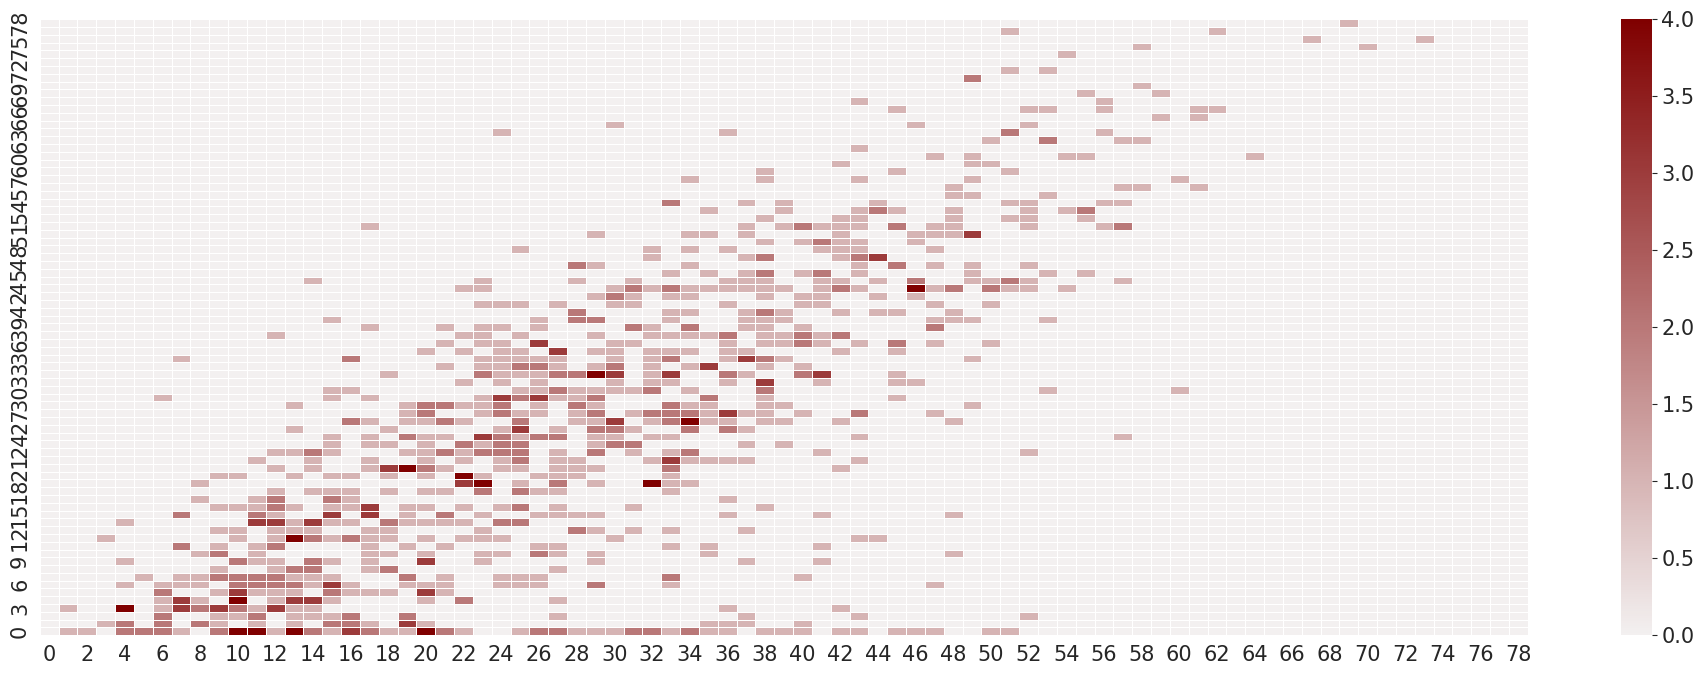

In [179]:
plt.rcParams.update({'font.size': 15})
sns.set_style("whitegrid")
plt.figure(figsize=(24, 8))
results = pd.DataFrame([y_test.values, preds], index=['actual', 'predicted']).T.round(0).astype(int)

ax= sns.heatmap(confusion_matrix(results.actual, results.predicted), cmap=sns.color_palette("light:maroon", as_cmap=True), linewidths=.5)
ax.set(xlabel='', ylabel='');
plt.ylim(reversed(plt.ylim()));
plt.yticks(rotation=90);

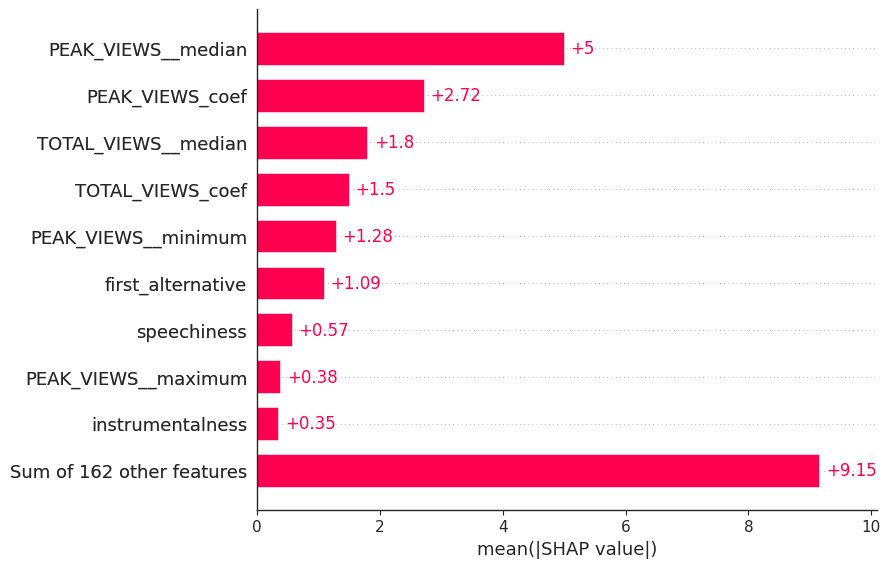

In [80]:
sns.set_style("white") 
explainer = shap.Explainer(xgb)
shap_values = explainer(X_after_train)
shap.plots.bar(shap_values)

### Results 

In [32]:
#XGBoost
pd.DataFrame(
    [[xgb_audio_mae,xgb_audio_mse, xgb_audio_sp[0]], [xgb_genres_mae,xgb_genres_mse, xgb_genres_sp[0]], [xgb_mel_features_mae, xgb_mel_features_mse, xgb_mel_features_sp[0]], [xgb_before_mae, xgb_before_mse, xgb_before_sp[0]],
    [xgb_static_views_mae, xgb_static_views_mse, xgb_static_views_sp[0]], [xgb_after_mae, xgb_after_mse, xgb_after_sp[0]]],
    columns=['MAE', 'MSE', "Spearman's Correlation"],
    index=["Spotify Tags", "Genres", "MFCC's", "Spotify Tags + Genres + MFCC's", "YouTube Views", "Spotify Tags + Genres + MFCC's + YouTube Views"],
)

,MAE,MSE,Spearman's Correlation
Spotify Tags,14.923792,334.927509,0.201690
Genres,14.122677,304.193309,0.288651
MFCC's,15.401487,347.507435,0.090301
Spotify Tags + Genres + MFCC's,14.091078,292.057621,0.315795
YouTube Views,10.048327,181.342007,0.660302
Spotify Tags + Genres + MFCC's + YouTube Views,9.189591,153.228625,0.712627


## Final Results

In [129]:
#Random Forest
pd.DataFrame(
    [[rf_audio_mae, rf_audio_mse, rf_audio_sp[0]], [rf_genres_mae, rf_genres_mse, rf_genres_sp[0]], [rf_mel_features_mae, rf_mel_features_mse, rf_mel_features_sp[0]], [rf_before_mae, rf_before_mse, rf_before_sp[0]],
    [rf_static_views_mae, rf_static_views_mse, rf_static_views_sp[0]], [rf_after_mae, rf_after_mse, rf_after_sp[0]]],
    columns=['MAE', 'MSE', "Spearman's Correlation"],
    index=["Spotify Tags", "Genres", "MFCC's", "Spotify Tags + Genres + MFCC's", "YouTube Views", "Spotify Tags + Genres + MFCC's + YouTube Views"],
)

,MAE,MSE,Spearman's Correlation
Spotify Tags,14.621747,311.699814,0.225711
Genres,14.131041,304.456320,0.288563
MFCC's,14.792751,319.839219,0.156902
Spotify Tags + Genres + MFCC's,14.289033,297.093866,0.319747
YouTube Views,9.803903,171.536245,0.674200
Spotify Tags + Genres + MFCC's + YouTube Views,9.525093,162.060409,0.697427


In [130]:
#LighGBM
pd.DataFrame(
    [[lgb_audio_mae,lgb_audio_mse, lgb_audio_sp[0]], [lgb_genres_mae, lgb_genres_mse, lgb_genres_sp[0]], [lgb_mel_features_mae, lgb_mel_features_mse, lgb_mel_features_sp[0]], [lgb_before_mae, lgb_before_mse, lgb_before_sp[0]],
    [lgb_static_views_mae, lgb_static_views_mse, lgb_static_views_sp[0]], [lgb_after_mae, lgb_after_mse, lgb_after_sp[0]]],
    columns=['MAE', 'MSE', "Spearman's Correlation"],
    index=["Spotify Tags", "Genres", "MFCC's", "Spotify Tags + Genres + MFCC's", "YouTube Views", "Spotify Tags + Genres + MFCC's + YouTube Views"],
)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=25, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=25
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. C

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use i

,MAE,MSE,Spearman's Correlation
Spotify Tags,14.630112,313.488848,0.224805
Genres,14.131041,298.945167,0.288399
MFCC's,14.820632,321.151487,0.144357
Spotify Tags + Genres + MFCC's,13.893123,288.173792,0.343602
YouTube Views,9.821561,172.050186,0.676847
Spotify Tags + Genres + MFCC's + YouTube Views,9.110595,156.448885,0.710052


In [56]:
#XGBoost
pd.DataFrame(
    [[xgb_audio_mae,xgb_audio_mse, xgb_audio_sp[0]], [xgb_genres_mae,xgb_genres_mse, xgb_genres_sp[0]], [xgb_mel_features_mae, xgb_mel_features_mse, xgb_mel_features_sp[0]], [xgb_before_mae, xgb_before_mse, xgb_before_sp[0]],
    [xgb_static_views_mae, xgb_static_views_mse, xgb_static_views_sp[0]], [xgb_after_mae, xgb_after_mse, xgb_after_sp[0]]],
    columns=['MAE', 'MSE', "Spearman's Correlation"],
    index=["Spotify Tags", "Genres", "MFCC's", "Spotify Tags + Genres + MFCC's", "YouTube Views", "Spotify Tags + Genres + MFCC's + YouTube Views"],
)

,MAE,MSE,Spearman's Correlation
Spotify Tags,14.673792,313.158922,0.223594
Genres,14.128253,304.695167,0.289930
MFCC's,15.088290,333.175651,0.132985
Spotify Tags + Genres + MFCC's,14.136617,291.906134,0.324991
YouTube Views,9.831784,172.794610,0.676328
Spotify Tags + Genres + MFCC's + YouTube Views,9.150558,152.399628,0.713300


# MLP 

## Spotify Tags

In [67]:
input_shape = X_audio_train.shape[1:]
def mlp_model(n_layers=3, input_shape=input_shape):

    audio_input = Input(shape=input_shape)

    x = Dense(units=32, activation='relu')(audio_input)
    for i in range(n_layers):
        x = Dense(units=32 * (2**i), activation='relu')(x)
        x = Dropout(0.3)(x)

    output = Dense(1)(x)
    model = Model(inputs=audio_input, outputs=output)

    model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999), loss="logcosh", metrics=["mse", "mae"])

    model.summary()

    return model

In [68]:
keras.backend.clear_session()
model = mlp_model()

checkpoint = ModelCheckpoint(filepath='mlp_model.h5', monitor="val_loss", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=15, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30)

history = model.fit(X_audio_train, y_train,
                    sample_weight=sample_weight,
                    validation_data=[X_audio_val, y_val],
                    batch_size=16,
                    epochs=100,
                    callbacks=[checkpoint, reduce_o_p, earlystopper])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense (Dense)               (None, 32)                928       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               8320  

In [61]:
model.load_weights("mlp_model.h5")

predictions = model.predict(X_audio_test).flatten().round(0).astype(int)

mlp_audio_mae = mean_absolute_error(y_test, predictions)
mlp_audio_mse = mean_squared_error(y_test, predictions)

temp = pd.DataFrame(model.predict(X_audio_test).flatten().round(0).astype(int), index=X_audio_test.index)
true_ranks = y_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

mlp_audio_sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
print(f"MAE: {mlp_audio_mae}\nMSE: {mlp_audio_mse}\nSpearman's Correlation {mlp_audio_sp[0]}")

MAE: 14.810408921933085
MSE: 317.5910780669145
Spearman's Correlation 0.18784866081179458


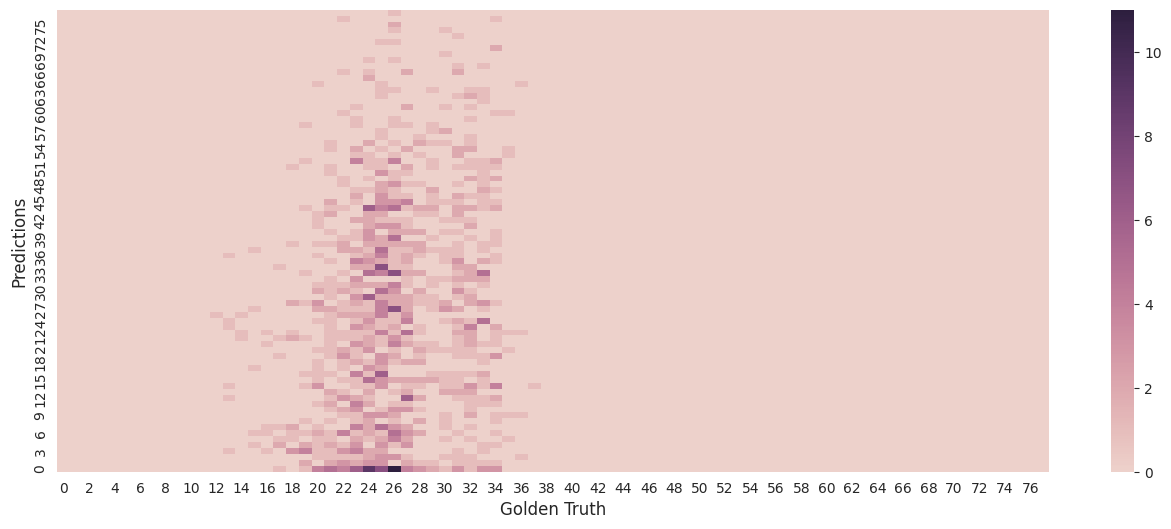

In [62]:
results = pd.DataFrame([y_test.values, predictions], index=['actual', 'predicted']).T.round(0).astype(int)
#results['differences'] = np.abs(results.actual - results.predicted)

ax= sns.heatmap(confusion_matrix(results.actual, results.predicted), cmap=sns.cubehelix_palette(as_cmap=True))
ax.set(xlabel='Golden Truth', ylabel='Predictions');
plt.ylim(reversed(plt.ylim()));
plt.yticks(rotation=90);

In [70]:
pd.cut(y_train, bins=3, labels = ["low", "medium", "high"]).value_counts()

low       5105
medium    3304
high       192
Name: popularity, dtype: int64

## Genres 

In [16]:
input_shape = X_genres_train.shape[1:]
def mlp_model(n_layers=2, input_shape=input_shape):

    audio_input = Input(shape=input_shape)

    x = Dense(units=32, activation='relu')(audio_input)
    for i in range(n_layers):
        x = Dense(units=32 * (2**i), activation='relu')(x)
        x = Dropout(0.2)(x)

    output = Dense(1)(x)
    model = Model(inputs=audio_input, outputs=output)

    model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999), loss="logcosh", metrics=["mse", "mae"])

    model.summary()

    return model

In [40]:
keras.backend.clear_session()
model = mlp_model()

checkpoint = ModelCheckpoint(filepath='mlp_model.h5', monitor="val_mae", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=15, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30)

history = model.fit(X_genres_train, y_train,
                    sample_weight=sample_weight,
                    validation_data=[X_genres_val, y_val],
                    batch_size=16,
                    epochs=100,
                    callbacks=[checkpoint, reduce_o_p, earlystopper])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 84)]              0         
                                                                 
 dense (Dense)               (None, 32)                2720      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65    

In [41]:
model.load_weights("mlp_model.h5")

predictions = model.predict(X_genres_test).flatten().round(0).astype(int)

mlp_genres_mae = mean_absolute_error(y_test, predictions)
mlp_genres_mse = mean_squared_error(y_test, predictions)

temp = pd.DataFrame(model.predict(X_genres_test).flatten().round(0).astype(int), index=X_genres_test.index)
true_ranks = y_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

mlp_genres_sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
print(f"MAE: {mlp_genres_mae}\nMSE: {mlp_genres_mse}\nSpearman's Correlation {mlp_genres_sp[0]}")

MAE: 14.306691449814126
MSE: 305.57806691449815
Spearman's Correlation 0.26632247679921245


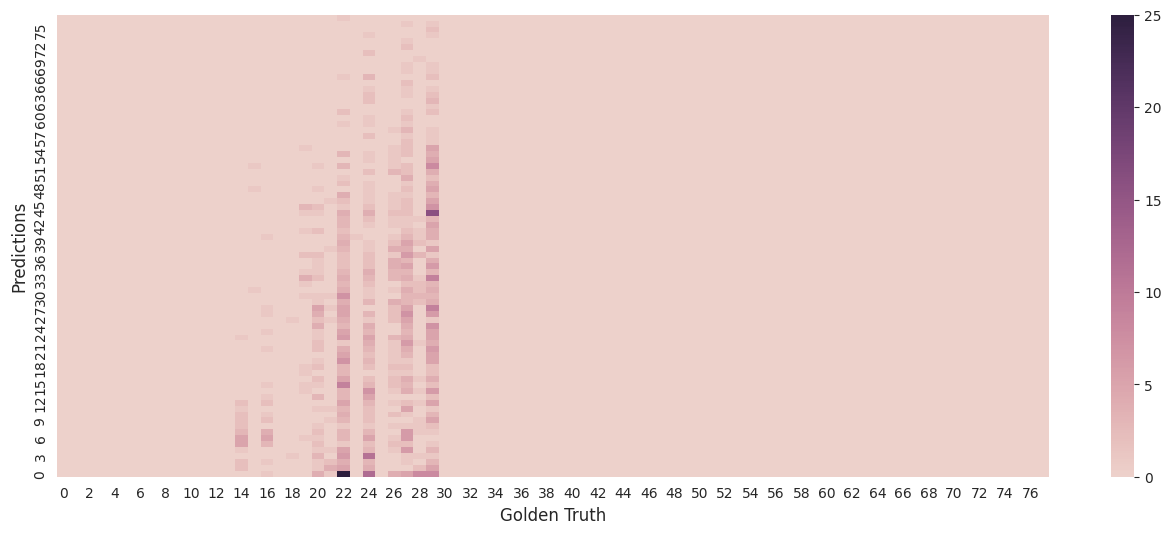

In [42]:
results = pd.DataFrame([y_test.values, predictions], index=['actual', 'predicted']).T.round(0).astype(int)
#results['differences'] = np.abs(results.actual - results.predicted)

ax= sns.heatmap(confusion_matrix(results.actual, results.predicted), cmap=sns.cubehelix_palette(as_cmap=True))
ax.set(xlabel='Golden Truth', ylabel='Predictions');
plt.ylim(reversed(plt.ylim()));
plt.yticks(rotation=90);

## MFCCs

In [14]:
input_shape = X_mel_features_train.shape[1:]
def mlp_model(n_layers=3, input_shape=input_shape):

    audio_input = Input(shape=input_shape)

    x = Dense(units=32, activation='relu')(audio_input)
    for i in range(n_layers):
        x = Dense(units=32 * (2**i), activation='relu')(x)
        x = Dropout(0.2)(x)

    output = Dense(1)(x)
    model = Model(inputs=audio_input, outputs=output)

    model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999), loss="logcosh", metrics=["mse", "mae"])

    model.summary()

    return model

In [15]:
keras.backend.clear_session()
model = mlp_model()

checkpoint = ModelCheckpoint(filepath='mlp_model.h5', monitor="val_loss", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=15, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30)

history = model.fit(X_mel_features_train, y_train,
                    sample_weight=sample_weight,
                    validation_data=[X_mel_features_val, y_val],
                    batch_size=16,
                    epochs=100,
                    callbacks=[checkpoint, reduce_o_p, earlystopper])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 39)]              0         
                                                                 
 dense (Dense)               (None, 32)                1280      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               8320  

Epoch 74/100
538/538 [==============================] - 1s 2ms/step - loss: 122.3807 - mse: 247.4923 - mae: 12.8840 - val_loss: 12.3898 - val_mse: 261.7756 - val_mae: 13.0588 - lr: 1.0000e-06
Epoch 75/100
538/538 [==============================] - 1s 2ms/step - loss: 122.2445 - mse: 246.7852 - mae: 12.8715 - val_loss: 12.3930 - val_mse: 261.9503 - val_mae: 13.0621 - lr: 1.0000e-06
Epoch 76/100
538/538 [==============================] - 1s 2ms/step - loss: 122.4621 - mse: 246.9344 - mae: 12.8936 - val_loss: 12.3807 - val_mse: 261.3005 - val_mae: 13.0496 - lr: 1.0000e-06
Epoch 77/100
538/538 [==============================] - 1s 2ms/step - loss: 122.2049 - mse: 246.0333 - mae: 12.8681 - val_loss: 12.3948 - val_mse: 262.0585 - val_mae: 13.0638 - lr: 1.0000e-06
Epoch 78/100
538/538 [==============================] - 1s 2ms/step - loss: 122.4019 - mse: 246.8263 - mae: 12.8868 - val_loss: 12.3911 - val_mse: 261.8662 - val_mae: 13.0599 - lr: 1.0000e-06
Epoch 79/100
538/538 [==================

In [17]:
model.load_weights("mlp_model.h5")

predictions = model.predict(X_mel_features_test).flatten().round(0).astype(int)

mlp_mel_features_mae = mean_absolute_error(y_test, predictions)
mlp_mel_features_mse = mean_squared_error(y_test, predictions)

temp = pd.DataFrame(model.predict(X_mel_features_test).flatten().round(0).astype(int), index=X_mel_features_test.index)
true_ranks = y_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

mlp_mel_features_sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
print(f"MAE: {mlp_mel_features_mae}\nMSE: {mlp_mel_features_mse}\nSpearman's Correlation {mlp_mel_features_sp[0]}")

34/34 [==============================] - 0s 655us/step
MAE: 14.945167286245352
MSE: 326.1942379182156
Spearman's Correlation 0.11338965691708208


## (T) Spotify Tags + Genres 

In [18]:
!pip install tensorflow_addons

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [19]:
from tensorflow_addons.metrics import RSquare

In [59]:
def build_mlp_model(hp, input_shape = X_audio_train.shape[1:]):
    # Creating the MLP model and tuning:

    # the number of hidden layers
    n_layers = hp.Int("n_layers", 1, 4)

    # the dropout layers
    dropout_p = hp.Float("dropout", min_value=0, max_value=0.6, step=0.05)

    audio_input = Input(shape=input_shape)
    #flatten = Flatten()(audio_input)

    hidden_layer = Dense(
        units=hp.Int(f"hidden{1}", min_value=32, max_value=256, step=16),
        activation=hp.Choice(f"dense_activation_{1}", values=["relu", "selu", "elu", "swish"]),
    )(audio_input)

    for i in range(n_layers):
        hidden_layer = Dense(
            units=hp.Int(f"hidden_{i}", min_value=32, max_value=256, step=16),
            activation=hp.Choice(f"dense_activation_{i}", values=["relu", "selu", "elu", "swish"]),
        )(hidden_layer)
        dropout = Dropout(dropout_p)(hidden_layer)

    output = Dense(1)(dropout)
    model = Model(inputs=audio_input, outputs=output)

    model.compile(
        loss="logcosh",
        optimizer=Adam(learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
        metrics=["mse", "mae", RSquare()],
    )

    print(model.summary())
    return model

{'n_layers': 3, 'dropout': 0.4, 'hidden1': 256, 'dense_activation_1': 'swish', 'hidden_0': 32, 'dense_activation_0': 'swish', 'learning_rate': 0.0001, 'hidden_1': 32, 'hidden_2': 32, 'dense_activation_2': 'swish', 'hidden_3': 32, 'dense_activation_3': 'swish'}

In [ ]:
def build_mlp_model(hp, input_shape = X_audio_train.shape[1:]):
    # Creating the MLP model and tuning:

    # the dropout layers
    dropout_p = 0.4

    genre_input = Input(shape=input_shape)
    
    hidden_layer = Dense(256, activation = 'swish')(audio_input)
    hidden_layer = Dense(32, activation = 'swish')(hidden_layer)
    dropout = Dropout(dropout_p)(dropout)
    hidden_layer = Dense(32, activation = 'swish')(hidden_layer)
    dropout = Dropout(dropout_p)(dropout)
    hidden_layer = Dense(32, activation = 'swish')(hidden_layer)
    dropout = Dropout(dropout_p)(dropout)

    output = Dense(1)(dropout)
        
    model.compile(
        loss="logcosh",
        optimizer=Adam(learning_rate= 0.0001),
        metrics=["mse", "mae", RSquare()],
    )

    print(model.summary())
    return model

In [67]:
keras.backend.clear_session()
mlp_tuner = kt.BayesianOptimization(build_mlp_model,
                                    objective='val_loss',
                                    max_trials=25,
                                    directory='mlp_dir_audio')

mlp_tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project mlp_dir_audio/untitled_project/oracle.json
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense (Dense)               (None, 32)                928       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,017
Trainable params: 2,017
Non-trainable params: 0
___________________________

In [68]:
#Creating an early stopping callback
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=20, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=60)

#Searching for the best hyperparameters of the mlp model
#with tf.device('/CPU:0'):
mlp_tuner.search(X_audio_train,y_train,
                epochs=100,
                validation_data=(X_audio_val,y_val),
                verbose=1,
                callbacks=[reduce_o_p, earlystopper])

Trial 25 Complete [00h 00m 50s]
val_loss: 12.211139678955078

Best val_loss So Far: 12.211139678955078
Total elapsed time: 00h 15m 20s
INFO:tensorflow:Oracle triggered exit


In [69]:
#Retrieving the best hyperparameter
best_mlp_hp = mlp_tuner.get_best_hyperparameters()[0]
print(best_mlp_hp.values)

#Building the optimal mlp model using the best hyperparameters the tuner gave us
best_mlp_model = mlp_tuner.hypermodel.build(best_mlp_hp)

{'n_layers': 3, 'dropout': 0.4, 'hidden1': 256, 'dense_activation_1': 'swish', 'hidden_0': 32, 'dense_activation_0': 'swish', 'learning_rate': 0.0001, 'hidden_1': 32, 'hidden_2': 32, 'dense_activation_2': 'swish', 'hidden_3': 32, 'dense_activation_3': 'swish'}
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28)]              0         
                                                                 
 dense_5 (Dense)             (None, 256)               7424      
                                                                 
 dense_6 (Dense)             (None, 32)                8224      
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 32)                1056   

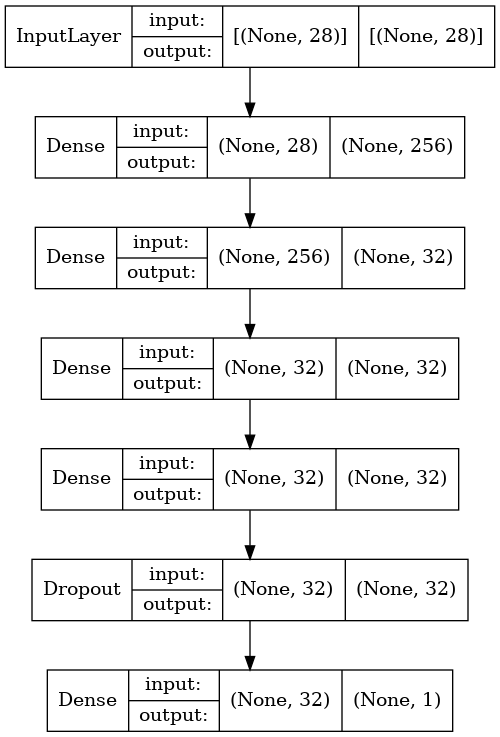

In [70]:
#Visualising the layers of the tuned optimal mlp model
tf.keras.utils.plot_model(best_mlp_model, show_shapes = True, show_layer_names = False)

In [71]:
checkpoint = ModelCheckpoint(filepath='mlp_model.h5', monitor="val_loss", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=20, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40)

keras.backend.clear_session()
#Training the optimal mlp model for 30 epochs 
best_mlp_history = best_mlp_model.fit(X_audio_train,y_train,
                                      sample_weight=sample_weight,
                                      validation_data=(X_audio_val,y_val),
                                      epochs=100,
                                      batch_size=16,
                                      callbacks=[checkpoint, reduce_o_p, earlystopper])

Epoch 1/100
538/538 [==============================] - 2s 2ms/step - loss: 178.2604 - mse: 533.0787 - mae: 18.4658 - r_square: -1.1368 - val_loss: 12.6165 - val_mse: 269.9753 - val_mae: 13.2906 - val_r_square: -0.0638 - lr: 1.0000e-04
Epoch 2/100
538/538 [==============================] - 1s 2ms/step - loss: 130.2558 - mse: 285.4717 - mae: 13.6724 - r_square: -0.1443 - val_loss: 12.3763 - val_mse: 256.3348 - val_mae: 13.0498 - val_r_square: -0.0100 - lr: 1.0000e-04
Epoch 3/100
538/538 [==============================] - 1s 2ms/step - loss: 129.0854 - mse: 279.6662 - mae: 13.5555 - r_square: -0.1210 - val_loss: 12.4741 - val_mse: 263.7784 - val_mae: 13.1490 - val_r_square: -0.0393 - lr: 1.0000e-04
Epoch 4/100
538/538 [==============================] - 1s 2ms/step - loss: 127.9233 - mse: 276.2111 - mae: 13.4392 - r_square: -0.1072 - val_loss: 12.4218 - val_mse: 261.1594 - val_mae: 13.0960 - val_r_square: -0.0290 - lr: 1.0000e-04
Epoch 5/100
538/538 [==============================] - 1s 2m

Epoch 36/100
538/538 [==============================] - 1s 2ms/step - loss: 122.1942 - mse: 254.3593 - mae: 12.8672 - r_square: -0.0196 - val_loss: 12.3323 - val_mse: 257.8159 - val_mae: 13.0101 - val_r_square: -0.0158 - lr: 1.0000e-04
Epoch 37/100
538/538 [==============================] - 1s 2ms/step - loss: 121.9269 - mse: 251.5084 - mae: 12.8407 - r_square: -0.0081 - val_loss: 12.2834 - val_mse: 254.1559 - val_mae: 12.9615 - val_r_square: -0.0014 - lr: 1.0000e-04
Epoch 38/100
538/538 [==============================] - 1s 2ms/step - loss: 122.2277 - mse: 253.3902 - mae: 12.8707 - r_square: -0.0157 - val_loss: 12.2770 - val_mse: 253.8752 - val_mae: 12.9550 - val_r_square: -3.1626e-04 - lr: 1.0000e-04
Epoch 39/100
538/538 [==============================] - 1s 2ms/step - loss: 122.0636 - mse: 252.4068 - mae: 12.8548 - r_square: -0.0117 - val_loss: 12.2293 - val_mse: 249.9348 - val_mae: 12.9049 - val_r_square: 0.0152 - lr: 1.0000e-04
Epoch 40/100
538/538 [==============================]

Epoch 71/100
538/538 [==============================] - 1s 2ms/step - loss: 120.9425 - mse: 250.8806 - mae: 12.7405 - r_square: -0.0056 - val_loss: 12.2947 - val_mse: 255.1560 - val_mae: 12.9722 - val_r_square: -0.0054 - lr: 1.0000e-05
Epoch 72/100
538/538 [==============================] - 1s 2ms/step - loss: 122.2460 - mse: 254.6426 - mae: 12.8715 - r_square: -0.0207 - val_loss: 12.3061 - val_mse: 255.9064 - val_mae: 12.9831 - val_r_square: -0.0083 - lr: 1.0000e-05
Epoch 73/100
538/538 [==============================] - 1s 2ms/step - loss: 122.4033 - mse: 253.5074 - mae: 12.8886 - r_square: -0.0162 - val_loss: 12.2895 - val_mse: 254.7559 - val_mae: 12.9673 - val_r_square: -0.0038 - lr: 1.0000e-05
Epoch 74/100
538/538 [==============================] - 1s 2ms/step - loss: 120.9831 - mse: 249.1201 - mae: 12.7460 - r_square: 0.0014 - val_loss: 12.2929 - val_mse: 254.9792 - val_mae: 12.9706 - val_r_square: -0.0047 - lr: 1.0000e-05
Epoch 75/100
538/538 [==============================] - 1

In [72]:
best_mlp_model.load_weights("mlp_model.h5")

predictions = best_mlp_model.predict(X_audio_test).flatten().round(0).astype(int)

mlp_audio_mae = mean_absolute_error(y_test, predictions)
mlp_audio_mse = mean_squared_error(y_test, predictions)

temp = pd.DataFrame(best_mlp_model.predict(X_audio_test).flatten().round(0).astype(int), index=X_audio_test.index)
true_ranks = y_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

mlp_audio_sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
metric = RSquare()
metric.update_state(y_test, predictions)
result = metric.result()
R2 = result.numpy()

print(f"MAE: {mlp_audio_mae}\nMSE: {mlp_audio_mse}\nSpearman's Correlation: {mlp_audio_sp[0]}\nR Squared: {R2}")

MAE: 14.79460966542751
MSE: 317.6291821561338
Spearman's Correlation: 0.18658832771068784
R Squared: 0.03409314155578613


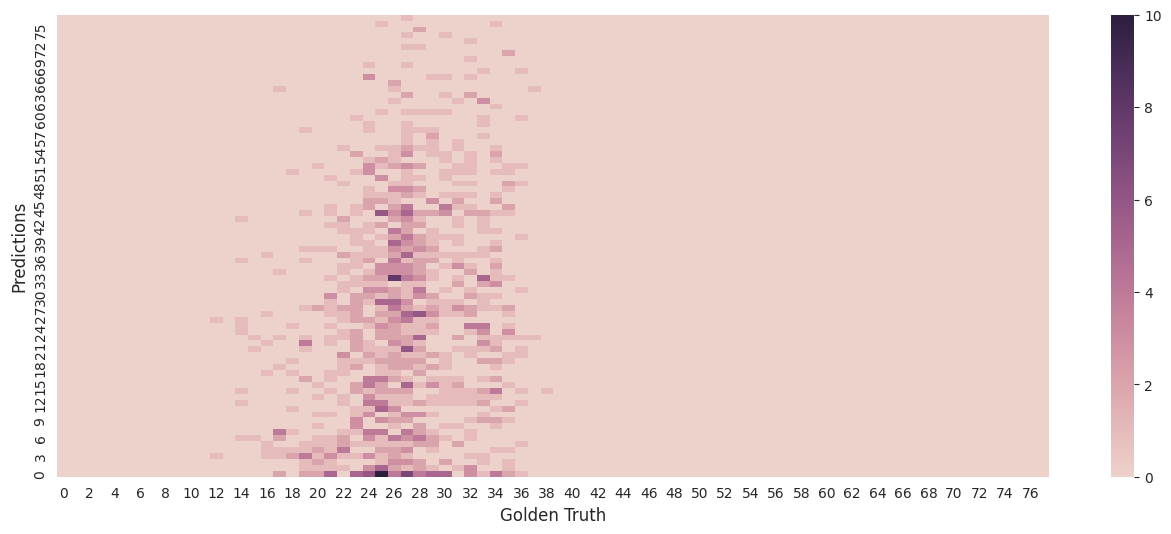

In [73]:
results = pd.DataFrame([y_test.values, predictions], index=['actual', 'predicted']).T.round(0).astype(int)
results['differences'] = np.abs(results.actual - results.predicted)

ax= sns.heatmap(confusion_matrix(results.actual, results.predicted), cmap=sns.cubehelix_palette(as_cmap=True))
ax.set(xlabel='Golden Truth', ylabel='Predictions');
plt.ylim(reversed(plt.ylim()));
plt.yticks(rotation=90);

In [74]:
def build_mlp_model(hp, input_shape = X_genres_train.shape[1:]):
    # Creating the MLP model and tuning:

    # the number of hidden layers
    n_layers = hp.Int("n_layers", 1, 4)

    # the dropout layers
    dropout_p = hp.Float("dropout", min_value=0, max_value=0.6, step=0.05)

    genre_input = Input(shape=input_shape)
    
    hidden_layer = Dense(
        units=hp.Int(f"hidden{1}", min_value=32, max_value=256, step=16),
        activation=hp.Choice(f"dense_activation_{1}", values=["relu", "selu", "elu", "swish"]),
    )(genre_input)

    for i in range(n_layers):
        hidden_layer = Dense(
            units=hp.Int(f"hidden_{i}", min_value=32, max_value=256, step=16),
            activation=hp.Choice(f"dense_activation_{i}", values=["relu", "selu", "elu", "swish"]),
        )(hidden_layer)
        dropout = Dropout(dropout_p)(hidden_layer)

    output = Dense(1)(dropout)
    model = Model(inputs=genre_input, outputs=output)

    model.compile(
        loss="logcosh",
        optimizer=Adam(learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
        metrics=["mse", "mae", RSquare()],
    )

    print(model.summary())
    return model

{'n_layers': 4, 'dropout': 0.6000000000000001, 'hidden1': 32, 'dense_activation_1': 'swish', 'hidden_0': 176, 'dense_activation_0': 'swish', 'learning_rate': 0.0001, 'hidden_1': 32, 'hidden_2': 96, 'dense_activation_2': 'selu', 'hidden_3': 256, 'dense_activation_3': 'relu'}



In [ ]:
def genres_model(hp, input_shape = X_genres_train.shape[1:]):
    # Creating the MLP model and tuning:

    # the number of hidden layers
    n_layers = 4

    # the dropout layers
    dropout_p = 0.6

    genre_input = Input(shape=input_shape)
    
    hidden_layer = Dense(32, activation = 'swish')(genre_input)
    hidden_layer = Dense(176, activation = 'swish')(hidden_layer)
    dropout = Dropout(dropout_p)(dropout)
    hidden_layer = Dense(32, activation = 'swish')(hidden_layer)
    dropout = Dropout(dropout_p)(dropout)
    hidden_layer = Dense(96, activation = 'selu')(hidden_layer)
    dropout = Dropout(dropout_p)(dropout)
    hidden_layer = Dense(256, activation = 'relu')(hidden_layer)
    dropout = Dropout(dropout_p)(dropout)

    output = Dense(1)(dropout)
    model = Model(inputs=genre_input, outputs=output)

    model.compile(
        loss="logcosh",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["mse", "mae"],
    )

    print(model.summary())
    return model

In [75]:
keras.backend.clear_session()
mlp_tuner = kt.BayesianOptimization(build_mlp_model,
                                    objective='val_loss',
                                    max_trials=25,
                                    directory='mlp_dir_genres')

mlp_tuner.search_space_summary()

#Creating an early stopping callback
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=20, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=60)

#Searching for the best hyperparameters of the mlp model
#with tf.device('/CPU:0'):
mlp_tuner.search(X_genres_train,y_train,
                epochs=100,
                validation_data=(X_genres_val,y_val),
                verbose=1,
                callbacks=[reduce_o_p, earlystopper])

Trial 25 Complete [00h 00m 32s]
val_loss: 12.227252006530762

Best val_loss So Far: 12.072543144226074
Total elapsed time: 00h 13m 46s
INFO:tensorflow:Oracle triggered exit


In [76]:
#Retrieving the best hyperparameter
best_mlp_hp = mlp_tuner.get_best_hyperparameters()[0]
print(best_mlp_hp.values)

#Building the optimal mlp model using the best hyperparameters the tuner gave us
best_mlp_model = mlp_tuner.hypermodel.build(best_mlp_hp)

checkpoint = ModelCheckpoint(filepath='mlp_model.h5', monitor="val_loss", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=20, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40)

keras.backend.clear_session()
#Training the optimal mlp model for 30 epochs 
best_mlp_history = best_mlp_model.fit(X_genres_train,y_train,
                                      sample_weight=sample_weight,
                                      validation_data=(X_genres_val,y_val),
                                      epochs=100,
                                      batch_size=16,
                                      callbacks=[checkpoint, reduce_o_p, earlystopper])

{'n_layers': 4, 'dropout': 0.6000000000000001, 'hidden1': 32, 'dense_activation_1': 'swish', 'hidden_0': 176, 'dense_activation_0': 'swish', 'learning_rate': 0.0001, 'hidden_1': 32, 'hidden_2': 96, 'dense_activation_2': 'selu', 'hidden_3': 256, 'dense_activation_3': 'relu'}
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 84)]              0         
                                                                 
 dense_6 (Dense)             (None, 32)                2720      
                                                                 
 dense_7 (Dense)             (None, 176)               5808      
                                                                 
 dense_8 (Dense)             (None, 32)                5664      
                                                                 
 dense_9 (Dense)             (None, 96)         

MAE: 14.447955390334572
MSE: 308.3791821561338
Spearman's Correlation: 0.22753504169603614
R Squared: 0.062222301959991455


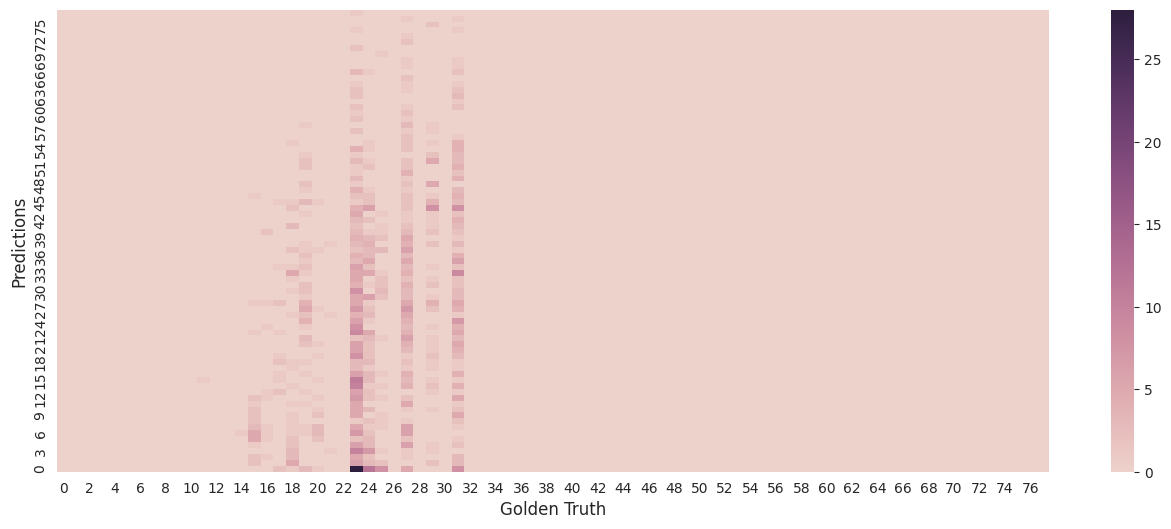

In [77]:
best_mlp_model.load_weights("mlp_model.h5")

predictions = best_mlp_model.predict(X_genres_test).flatten().round(0).astype(int)

mlp_genres_mae = mean_absolute_error(y_test, predictions)
mlp_genres_mse = mean_squared_error(y_test, predictions)

temp = pd.DataFrame(best_mlp_model.predict(X_genres_test).flatten().round(0).astype(int), index=X_genres_test.index)
true_ranks = y_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

metric = RSquare()
metric.update_state(y_test, predictions)
result = metric.result()
R2 = result.numpy()

mlp_genres_sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
print(f"MAE: {mlp_genres_mae}\nMSE: {mlp_genres_mse}\nSpearman's Correlation: {mlp_genres_sp[0]}\nR Squared: {R2}")

results = pd.DataFrame([y_test.values, predictions], index=['actual', 'predicted']).T.round(0).astype(int)
results['differences'] = np.abs(results.actual - results.predicted)

ax= sns.heatmap(confusion_matrix(results.actual, results.predicted), cmap=sns.cubehelix_palette(as_cmap=True))
ax.set(xlabel='Golden Truth', ylabel='Predictions');
plt.ylim(reversed(plt.ylim()));
plt.yticks(rotation=90);

## YouTube Views 

In [36]:
input_shape = X_static_views_train.shape[1:]
def mlp_model(n_layers=6, input_shape=input_shape):

    audio_input = Input(shape=input_shape)

    x = Dense(units=32, activation='relu')(audio_input)
    for i in range(n_layers):
        x = Dense(units=32 * (2**i), activation='relu')(x)
        x = Dropout(0.2)(x)

    output = Dense(1)(x)
    model = Model(inputs=audio_input, outputs=output)

    model.compile(optimizer=Adam(learning_rate=1e-4, beta_1=0.99, beta_2=0.999), loss="logcosh", metrics=["mse", "mae"])

    model.summary()

    return model

In [37]:
keras.backend.clear_session()
model = mlp_model()

checkpoint = ModelCheckpoint(filepath='mlp_model.h5', monitor="val_loss", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=15, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30)

history = model.fit(X_static_views_train, y_train,
                    sample_weight=sample_weight,
                    validation_data=[X_static_views_val, y_val],
                    batch_size=16,
                    epochs=100,
                    callbacks=[checkpoint, reduce_o_p, earlystopper])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense (Dense)               (None, 32)                672       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               8320  

Epoch 32/100
538/538 [==============================] - 1s 2ms/step - loss: 81.5195 - mse: 128.9625 - mae: 8.7998 - val_loss: 7.4342 - val_mse: 107.8311 - val_mae: 8.0926 - lr: 1.0000e-04
Epoch 33/100
538/538 [==============================] - 1s 2ms/step - loss: 83.1229 - mse: 131.5845 - mae: 8.9604 - val_loss: 7.2259 - val_mse: 101.7472 - val_mae: 7.8880 - lr: 1.0000e-04
Epoch 34/100
538/538 [==============================] - 1s 2ms/step - loss: 82.2534 - mse: 129.8736 - mae: 8.8747 - val_loss: 7.2256 - val_mse: 99.6323 - val_mae: 7.8910 - lr: 1.0000e-04
Epoch 35/100
538/538 [==============================] - 1s 2ms/step - loss: 79.9081 - mse: 123.4938 - mae: 8.6385 - val_loss: 7.0869 - val_mse: 97.4958 - val_mae: 7.7458 - lr: 1.0000e-04
Epoch 36/100
538/538 [==============================] - 1s 2ms/step - loss: 82.3099 - mse: 129.9759 - mae: 8.8811 - val_loss: 7.1986 - val_mse: 98.1177 - val_mae: 7.8627 - lr: 1.0000e-04
Epoch 37/100
538/538 [==============================] - 1s 2ms/

Epoch 76/100
538/538 [==============================] - 1s 2ms/step - loss: 74.8650 - mse: 112.5510 - mae: 8.1339 - val_loss: 6.9337 - val_mse: 94.3328 - val_mae: 7.5975 - lr: 1.0000e-05
Epoch 77/100
538/538 [==============================] - 1s 2ms/step - loss: 74.4419 - mse: 112.6066 - mae: 8.0902 - val_loss: 6.9829 - val_mse: 95.5100 - val_mae: 7.6461 - lr: 1.0000e-05
Epoch 78/100
538/538 [==============================] - 1s 2ms/step - loss: 74.9006 - mse: 112.6094 - mae: 8.1359 - val_loss: 6.9369 - val_mse: 93.8330 - val_mae: 7.6024 - lr: 1.0000e-05
Epoch 79/100
538/538 [==============================] - 1s 2ms/step - loss: 74.9443 - mse: 113.1306 - mae: 8.1431 - val_loss: 6.9052 - val_mse: 93.3385 - val_mae: 7.5675 - lr: 1.0000e-05
Epoch 80/100
538/538 [==============================] - 1s 2ms/step - loss: 75.0104 - mse: 113.0445 - mae: 8.1473 - val_loss: 6.9944 - val_mse: 94.4646 - val_mae: 7.6592 - lr: 1.0000e-05
Epoch 81/100
538/538 [==============================] - 1s 2ms/st

In [38]:
model.load_weights("mlp_model.h5")

predictions = model.predict(X_static_views_test).flatten().round(0).astype(int)

mlp_static_views_mae = mean_absolute_error(y_test, predictions)
mlp_static_views_mse = mean_squared_error(y_test, predictions)

temp = pd.DataFrame(model.predict(X_static_views_test).flatten().round(0).astype(int), index=X_static_views_test.index)
true_ranks = y_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

mlp_static_views_sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
print(f"MAE: {mlp_static_views_mae}\nMSE: {mlp_static_views_mse}\nSpearman's Correlation {mlp_static_views_sp[0]}")

34/34 [==============================] - 0s 676us/step
MAE: 9.899628252788103
MSE: 172.4442379182156
Spearman's Correlation 0.6783722977166095


## (T) Spotify Tags + Genres + MFCC's + YouTube Views 

In [39]:
def build_mlp_model(hp, input_shape = X_after_train.shape[1:]):
    # Creating the MLP model and tuning:

    # the number of hidden layers
    n_layers = hp.Int("n_layers", 1, 6)

    # the dropout layers
    dropout_p = hp.Float("dropout", min_value=0, max_value=0.6, step=0.05)

    audio_input = Input(shape=input_shape)
    flatten = Flatten()(audio_input)

    hidden_layer = Dense(
        units=hp.Int(f"hidden{1}", min_value=32, max_value=256, step=16),
        activation=hp.Choice(f"dense_activation_{1}", values=["relu", "selu", "elu", "swish"]),
    )(flatten)

    for i in range(n_layers):
        hidden_layer = Dense(
            units=hp.Int(f"hidden_{i}", min_value=32, max_value=256, step=16),
            activation=hp.Choice(f"dense_activation_{i}", values=["relu", "selu", "elu", "swish"]),
        )(hidden_layer)
        dropout = Dropout(dropout_p)(hidden_layer)

    output = Dense(1)(dropout)
    model = Model(inputs=audio_input, outputs=output)

    model.compile(
        loss="logcosh",
        optimizer=Adam(learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
        metrics=["mse", "mae"],
    )

    print(model.summary())
    return model

In [40]:
keras.backend.clear_session()
mlp_tuner = kt.BayesianOptimization(build_mlp_model,
                                    objective='val_loss',
                                    max_trials=5,
                                    directory='mlp_dir_after')

mlp_tuner.search_space_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 171)]             0         
                                                                 
 flatten (Flatten)           (None, 171)               0         
                                                                 
 dense (Dense)               (None, 32)                5504      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6,593
Trainable params: 6,593
Non-trainable par

In [41]:
#Creating an early stopping callback
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=20, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40)

#Searching for the best hyperparameters of the mlp model
#with tf.device('/CPU:0'):
mlp_tuner.search(X_after_train,y_train,
                epochs=50,
                validation_data=(X_after_val,y_val),
                verbose=1,
                callbacks=[reduce_o_p, earlystopper])

Trial 5 Complete [00h 00m 21s]
val_loss: 8.781200408935547

Best val_loss So Far: 8.079540252685547
Total elapsed time: 00h 02m 13s
INFO:tensorflow:Oracle triggered exit


In [42]:
#Retrieving the best hyperparameter
best_mlp_hp = mlp_tuner.get_best_hyperparameters()[0]
print(best_mlp_hp.values)

#Building the optimal mlp model using the best hyperparameters the tuner gave us
best_mlp_model = mlp_tuner.hypermodel.build(best_mlp_hp)

{'n_layers': 5, 'dropout': 0.6000000000000001, 'hidden1': 256, 'dense_activation_1': 'relu', 'hidden_0': 256, 'dense_activation_0': 'relu', 'learning_rate': 0.01, 'hidden_1': 256, 'hidden_2': 208, 'dense_activation_2': 'relu', 'hidden_3': 256, 'dense_activation_3': 'swish', 'hidden_4': 256, 'dense_activation_4': 'relu'}
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 171)]             0         
                                                                 
 flatten_1 (Flatten)         (None, 171)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               44032     
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 

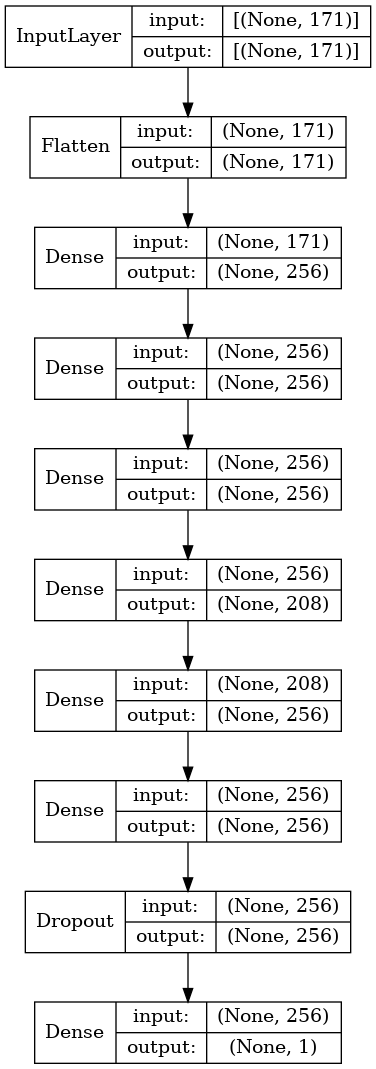

In [43]:
#Visualising the layers of the tuned optimal mlp model
tf.keras.utils.plot_model(best_mlp_model, show_shapes = True, show_layer_names = False)

In [44]:
checkpoint = ModelCheckpoint(filepath='mlp_model.h5', monitor="val_loss", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=20, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40)

keras.backend.clear_session()
#Training the optimal mlp model for 30 epochs 
best_mlp_history = best_mlp_model.fit(X_after_train,y_train,
                                      sample_weight=sample_weight,
                                      validation_data=(X_after_val,y_val),
                                      epochs=100,
                                      batch_size=16,
                                      callbacks=[checkpoint, reduce_o_p, earlystopper])

Epoch 1/100
538/538 [==============================] - 1s 2ms/step - loss: 130.0429 - mse: 330.2697 - mae: 13.6527 - val_loss: 11.5825 - val_mse: 224.6075 - val_mae: 12.2570 - lr: 0.0100
Epoch 2/100
538/538 [==============================] - 1s 2ms/step - loss: 118.2596 - mse: 234.3726 - mae: 12.4764 - val_loss: 11.1847 - val_mse: 205.8590 - val_mae: 11.8584 - lr: 0.0100
Epoch 3/100
538/538 [==============================] - 1s 2ms/step - loss: 114.2172 - mse: 220.8877 - mae: 12.0750 - val_loss: 10.8612 - val_mse: 200.5974 - val_mae: 11.5328 - lr: 0.0100
Epoch 4/100
538/538 [==============================] - 1s 2ms/step - loss: 113.8999 - mse: 244.8277 - mae: 12.0431 - val_loss: 10.8699 - val_mse: 191.3022 - val_mae: 11.5443 - lr: 0.0100
Epoch 5/100
538/538 [==============================] - 1s 2ms/step - loss: 113.2207 - mse: 220.9319 - mae: 11.9742 - val_loss: 11.4794 - val_mse: 221.7213 - val_mae: 12.1562 - lr: 0.0100
Epoch 6/100
538/538 [==============================] - 1s 2ms/ste

Epoch 45/100
538/538 [==============================] - 1s 2ms/step - loss: 99.5679 - mse: 170.6574 - mae: 10.6113 - val_loss: 8.8952 - val_mse: 137.0350 - val_mae: 9.5639 - lr: 0.0100
Epoch 46/100
538/538 [==============================] - 1s 2ms/step - loss: 103.8515 - mse: 182.6087 - mae: 11.0398 - val_loss: 9.4637 - val_mse: 156.0028 - val_mae: 10.1283 - lr: 0.0100
Epoch 47/100
538/538 [==============================] - 1s 2ms/step - loss: 93.6864 - mse: 153.2500 - mae: 10.0217 - val_loss: 9.1189 - val_mse: 142.7842 - val_mae: 9.7854 - lr: 0.0100
Epoch 48/100
538/538 [==============================] - 1s 2ms/step - loss: 95.1398 - mse: 158.3817 - mae: 10.1662 - val_loss: 8.6309 - val_mse: 133.0966 - val_mae: 9.2940 - lr: 0.0100
Epoch 49/100
538/538 [==============================] - 1s 2ms/step - loss: 93.7939 - mse: 179.5766 - mae: 10.0290 - val_loss: 8.5459 - val_mse: 131.0863 - val_mae: 9.2106 - lr: 0.0100
Epoch 50/100
538/538 [==============================] - 1s 2ms/step - los

In [45]:
best_mlp_model.load_weights("mlp_model.h5")

predictions = best_mlp_model.predict(X_after_test).flatten().round(0).astype(int)

mlp_after_mae = mean_absolute_error(y_test, predictions)
mlp_after_mse = mean_squared_error(y_test, predictions)

temp = pd.DataFrame(best_mlp_model.predict(X_after_test).flatten().round(0).astype(int), index=X_after_test.index)
true_ranks = y_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

mlp_after_sp = stats.spearmanr(true_ranks, predicted_ranks) #0.72
print(f"MAE: {mlp_after_mae}\nMSE: {mlp_after_mse}\nSpearman's Correlation {mlp_after_sp[0]}")

34/34 [==============================] - 0s 657us/step
MAE: 10.58085501858736
MSE: 195.75371747211895
Spearman's Correlation 0.6439896901978132


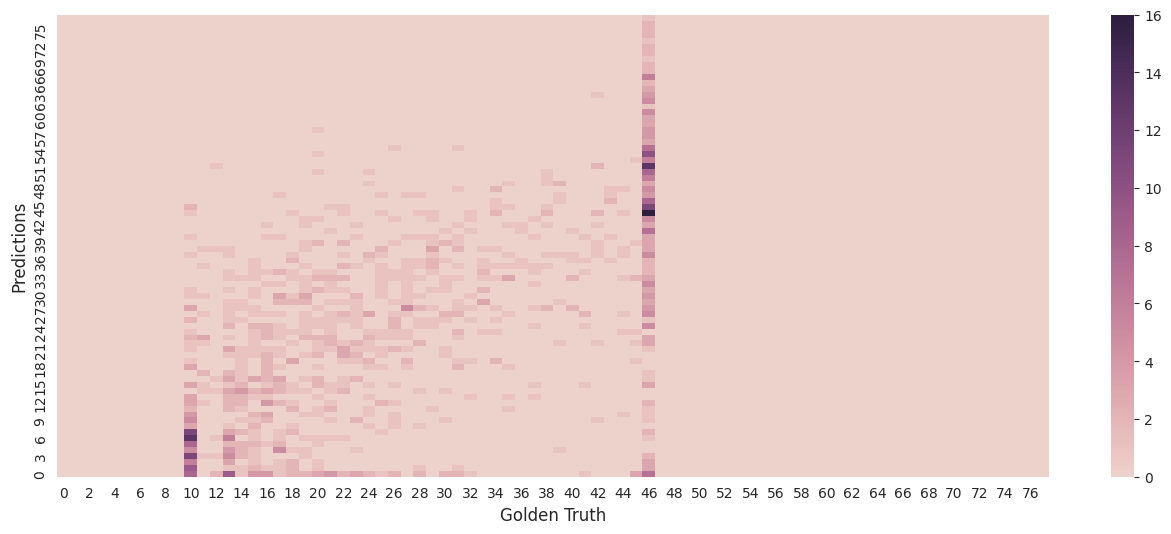

In [46]:
results = pd.DataFrame([y_test.values, predictions], index=['actual', 'predicted']).T.round(0).astype(int)

ax= sns.heatmap(confusion_matrix(results.actual, results.predicted), cmap=sns.cubehelix_palette(as_cmap=True))
ax.set(xlabel='Golden Truth', ylabel='Predictions');
plt.ylim(reversed(plt.ylim()));
plt.yticks(rotation=90);

## Results 

In [47]:
#MLP
pd.DataFrame(
    [[mlp_audio_mae,mlp_audio_mse,mlp_audio_sp[0]], [mlp_genres_mae, mlp_genres_mse, mlp_genres_sp[0]], [mlp_mel_features_mae, mlp_mel_features_mse, mlp_mel_features_sp[0]], [mlp_before_mae, mlp_before_mse, mlp_before_sp[0]],
    [mlp_static_views_mae, mlp_static_views_mse, mlp_static_views_sp[0]], [mlp_after_mae, mlp_after_mse, mlp_after_sp[0]]],
    columns=['MAE', 'MSE', "Spearman's Correlation"],
    index=["Spotify Tags", "Genres", "MFCC's", "Spotify Tags + Genres + MFCC's", "YouTube Views", "Spotify Tags + Genres + MFCC's + YouTube Views"],
)

,MAE,MSE,Spearman's Correlation
Spotify Tags,14.776022,319.902416,0.203167
Genres,14.942379,327.066914,0.113390
MFCC's,14.945167,326.194238,0.113390
Spotify Tags + Genres + MFCC's,13.853160,287.516729,0.346584
YouTube Views,9.899628,172.444238,0.678372
Spotify Tags + Genres + MFCC's + YouTube Views,10.580855,195.753717,0.643990


## (T) Audio + Genres 

In [7]:
def build_mlp_model(hp, shape=input_shape):
    # Creating the MLP model and tuning:

    # the number of hidden layers
    x_layers = hp.Int("n_layers", 1, 6)
    y_layers = hp.Int("n_layers", 1, 6)
    n_layers = hp.Int("n_layers", 1, 6)
    # the dropout layers
    dropout_x = hp.Float("dropout_x", min_value=0, max_value=0.5, step=0.05)
    dropout_y = hp.Float("dropout_y", min_value=0, max_value=0.5, step=0.05)
    dropout_ = hp.Float("dropout", min_value=0, max_value=0.5, step=0.05)
    
    #Inputs
    audio_input = Input(shape=(X_audio_train.shape[1:]), name="AUDIO_INPUT")
    genre_input = Input(shape=(X_genre_train.shape[1:]), name="GENRES_INPUT")

    x = Dense(units=hp.Int(f"audio_hidden{1}", min_value=32, max_value=256, step=16),
              activation=hp.Choice(f"dense_activation_{1}", values=["relu", "selu", "elu", "swish"]))(audio_input)

    for i in range(x_layers):
        x = Dense(units=hp.Int(f"audio_hidden_{i}", min_value=32, max_value=256, step=16),
                  activation=hp.Choice(f"dense_activation_{i}", values=["relu", "selu", "elu", "swish"]),)(x)
        dropout = Dropout(dropout_x)(x)
        

    y = Dense(units=hp.Int(f"genre_hidden{1}", min_value=32, max_value=256, step=16),
                         activation=hp.Choice(f"dense_activation_{1}", values=["relu", "selu", "elu", "swish"]))(genre_input)

    for i in range(y_layers):
        y = Dense(units=hp.Int(f"genre_hidden_{i}", min_value=32, max_value=256, step=16),
                             activation=hp.Choice(f"dense_activation_{i}", values=["relu", "selu", "elu", "swish"]),)(y)
        dropout = Dropout(dropout_y)(y)
        
    combined = Concatenate(axis=1)([x, y])
    n = Dense(units=hp.Int(f"hidden{1}", min_value=32, max_value=256, step=16),
              activation=hp.Choice(f"dense_activation_{1}", values=["relu", "selu", "elu", "swish"]))(combined)
    
    for i in range(n_layers):
        n = Dense(units=hp.Int(f"hidden_{i}", min_value=32, max_value=256, step=16),
                             activation=hp.Choice(f"dense_activation_{i}", values=["relu", "selu", "elu", "swish"]),)(n)
        dropout = Dropout(dropout_)(n)

    output = Dense(1)(dropout)
    model = Model(inputs=[audio_input, genre_input], outputs=output)

    model.compile(loss="logcosh", optimizer=Adam(learning_rate=hp.Choice("learning_rate", values=[1e-4, 1e-5, 1e-6])), metrics=["mse", "mae"])
    model.summary()
    
    return model

In [17]:
keras.backend.clear_session()
# Creating the Bayesian optimization tuner
mlp_tuner_3 = kt.BayesianOptimization(build_mlp_model, 
                                      objective="val_loss", 
                                      max_trials=20, 
                                      directory="mlp_dir_3")

mlp_tuner_3.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project mlp_dir_3/untitled_project/oracle.json
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 AUDIO_INPUT (InputLayer)       [(None, 28)]         0           []                               
                                                                                                  
 GENRES_INPUT (InputLayer)      [(None, 84)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 32)           928         ['AUDIO_INPUT[0][0]']            
                                                                                                  
 dense_2 (Dense)                (None, 32)           2720        ['GENRES_INPUT[0][0]']           


In [18]:
# Creating an early stopping callback
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=20, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40)

# Searching for the best hyperparameters of the mlp model
# with tf.device('/CPU:0'):
mlp_tuner_3.search(
    [X_audio_train, X_genre_train], y_train,
    epochs=50,
    validation_data=[[X_audio_val, X_genre_val], y_val],
    verbose=1,
    callbacks=[reduce_o_p, earlystopper],
)

INFO:tensorflow:Oracle triggered exit


In [19]:
#Retrieving the best hyperparameter
best_mlp_hp_3 = mlp_tuner_3.get_best_hyperparameters()[0]
print(best_mlp_hp_3.values)

#Building the optimal mlp model using the best hyperparameters the tuner gave us
best_mlp_model_3 = mlp_tuner_3.hypermodel.build(best_mlp_hp_3)

{'n_layers': 6, 'dropout_x': 0.5, 'dropout_y': 0.5, 'dropout': 0.0, 'audio_hidden1': 128, 'dense_activation_1': 'swish', 'audio_hidden_0': 32, 'dense_activation_0': 'swish', 'genre_hidden1': 208, 'genre_hidden_0': 32, 'hidden1': 256, 'hidden_0': 256, 'learning_rate': 0.0001, 'audio_hidden_1': 32, 'audio_hidden_2': 32, 'dense_activation_2': 'relu', 'audio_hidden_3': 32, 'dense_activation_3': 'swish', 'audio_hidden_4': 32, 'dense_activation_4': 'relu', 'genre_hidden_1': 32, 'genre_hidden_2': 32, 'genre_hidden_3': 32, 'genre_hidden_4': 32, 'hidden_1': 32, 'hidden_2': 32, 'hidden_3': 32, 'hidden_4': 256, 'audio_hidden_5': 80, 'dense_activation_5': 'relu', 'genre_hidden_5': 112, 'hidden_5': 208}
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 AUDIO_INPUT (InputLayer)       [(None, 28)]         0           []                  

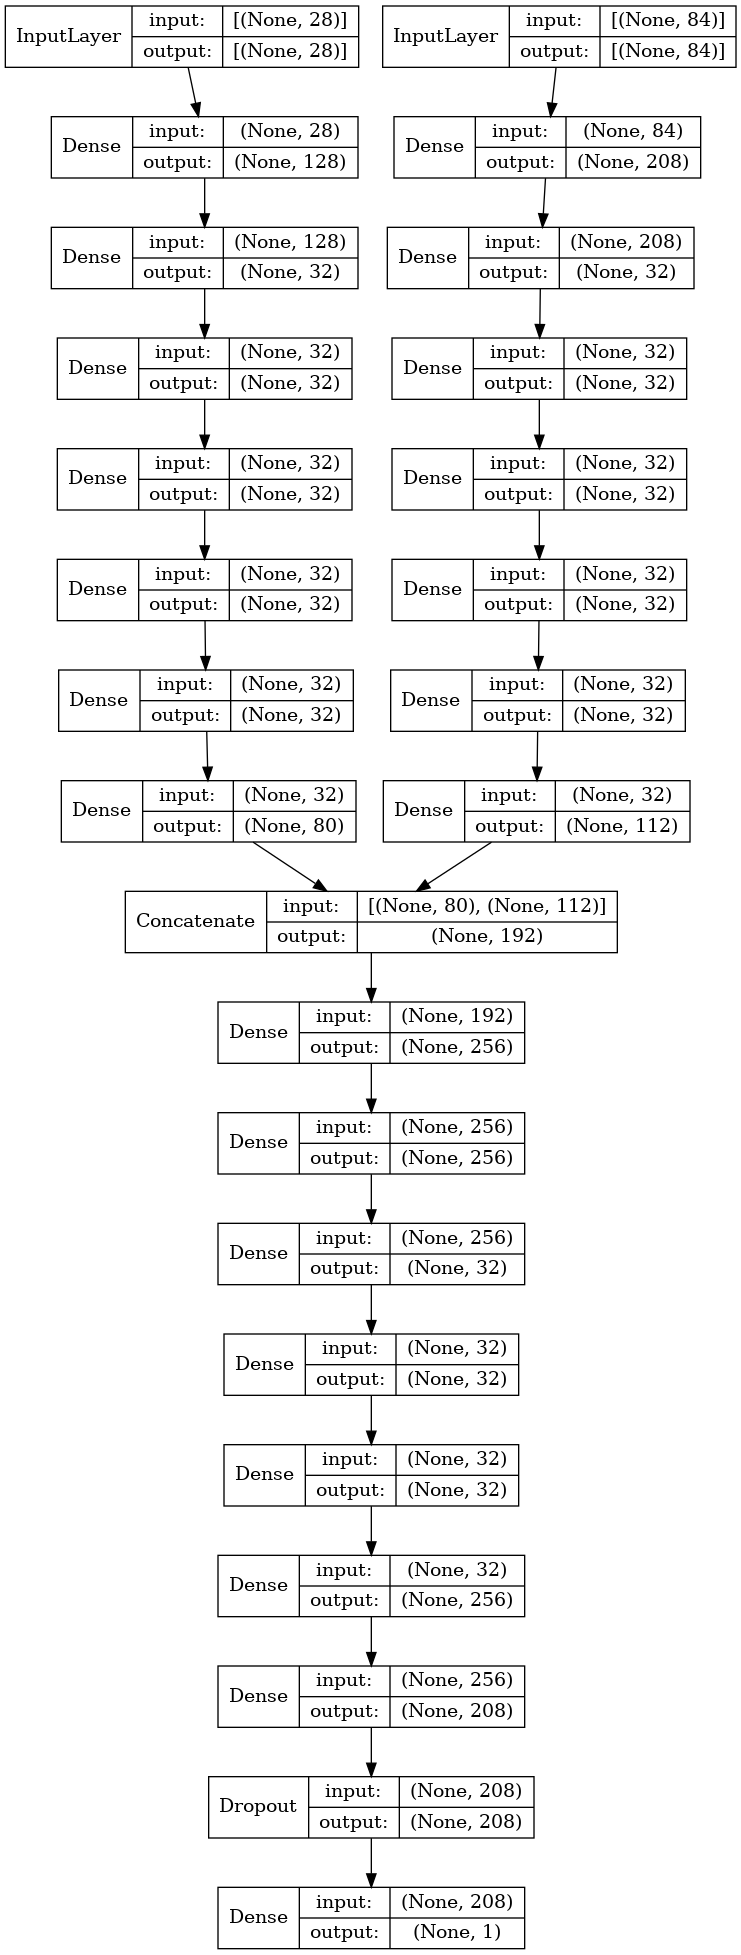

In [20]:
#Visualising the layers of the tuned optimal mlp model
tf.keras.utils.plot_model(best_mlp_model_3, show_shapes = True, show_layer_names = False)

In [21]:
checkpoint = ModelCheckpoint(filepath='mlp_model_3.h5', monitor="val_loss", save_best_only=True)
reduce_o_p = ReduceLROnPlateau(monitor="val_loss", patience=20, min_lr=1e-7, mode="min")
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40)

#Training the optimal mlp model for 30 epochs 
best_mlp_history = best_mlp_model_3.fit([X_audio_train, X_genre_train], y_train,
                                        sample_weight = sample_weight,
                                        epochs=100,
                                        validation_data=[[X_audio_val, X_genre_val], y_val],
                                        batch_size=16,
                                        callbacks=[checkpoint, reduce_o_p, earlystopper])

Epoch 1/100
538/538 [==============================] - 3s 4ms/step - loss: 142.2458 - mse: 348.6322 - mae: 14.8703 - val_loss: 12.1771 - val_mse: 246.7294 - val_mae: 12.8556 - lr: 1.0000e-04
Epoch 2/100
538/538 [==============================] - 2s 3ms/step - loss: 117.6291 - mse: 232.5535 - mae: 12.4091 - val_loss: 12.1968 - val_mse: 252.0995 - val_mae: 12.8720 - lr: 1.0000e-04
Epoch 3/100
538/538 [==============================] - 2s 3ms/step - loss: 115.6714 - mse: 227.8561 - mae: 12.2140 - val_loss: 12.4094 - val_mse: 268.6989 - val_mae: 13.0813 - lr: 1.0000e-04
Epoch 4/100
538/538 [==============================] - 2s 3ms/step - loss: 114.1698 - mse: 224.0768 - mae: 12.0633 - val_loss: 12.0959 - val_mse: 251.9400 - val_mae: 12.7674 - lr: 1.0000e-04
Epoch 5/100
538/538 [==============================] - 2s 3ms/step - loss: 113.3984 - mse: 222.3489 - mae: 11.9860 - val_loss: 12.1104 - val_mse: 249.2387 - val_mae: 12.7822 - lr: 1.0000e-04
Epoch 6/100
538/538 [========================

Epoch 44/100
538/538 [==============================] - 2s 3ms/step - loss: 109.5070 - mse: 212.8109 - mae: 11.5929 - val_loss: 12.2109 - val_mse: 259.1042 - val_mae: 12.8833 - lr: 1.0000e-05
Epoch 45/100
538/538 [==============================] - 2s 3ms/step - loss: 109.4329 - mse: 212.2885 - mae: 11.5848 - val_loss: 12.2320 - val_mse: 261.1774 - val_mae: 12.9041 - lr: 1.0000e-05
Epoch 46/100
538/538 [==============================] - 2s 3ms/step - loss: 109.4400 - mse: 212.4387 - mae: 11.5860 - val_loss: 12.2374 - val_mse: 261.6374 - val_mae: 12.9098 - lr: 1.0000e-05
Epoch 47/100
538/538 [==============================] - 2s 3ms/step - loss: 109.4472 - mse: 212.4083 - mae: 11.5865 - val_loss: 12.2296 - val_mse: 260.9581 - val_mae: 12.9014 - lr: 1.0000e-05
Epoch 48/100
538/538 [==============================] - 2s 3ms/step - loss: 109.4203 - mse: 212.4447 - mae: 11.5835 - val_loss: 12.2825 - val_mse: 264.5845 - val_mae: 12.9555 - lr: 1.0000e-05


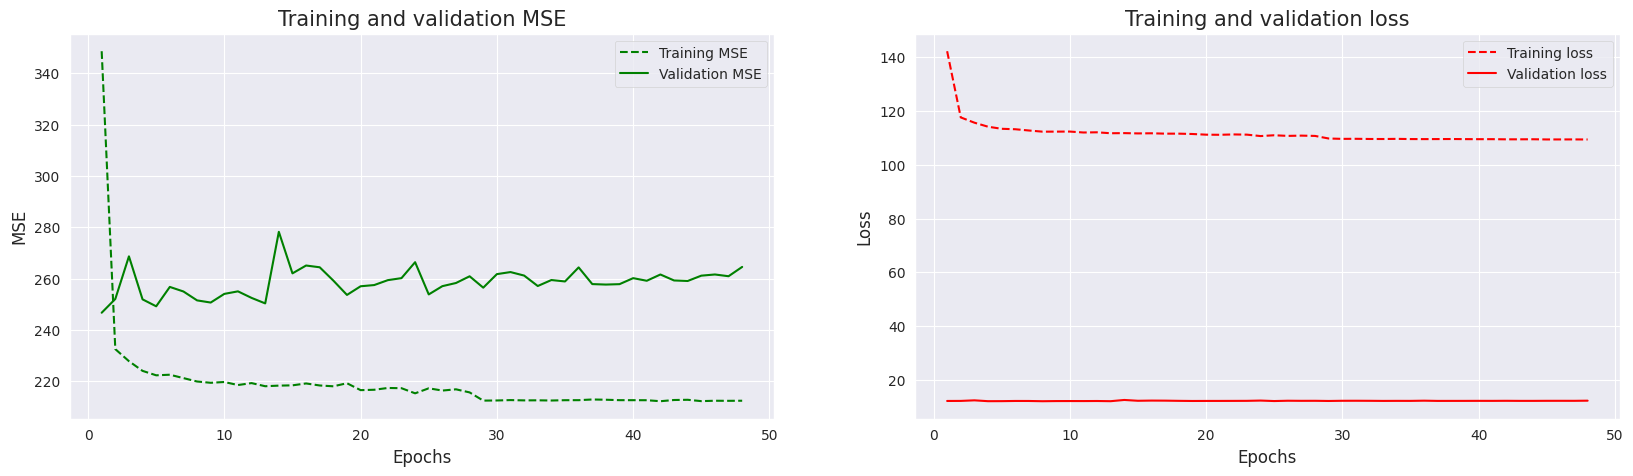

In [22]:
plot_learning_curves(best_mlp_history.history)

In [23]:
best_mlp_model_3.load_weights("mlp_model_3.h5")
best_mlp_model_3.evaluate([X_audio_test, X_genre_test], y_test)

34/34 [==============================] - 0s 1ms/step - loss: 13.0036 - mse: 287.9681 - mae: 13.6761


[13.003605842590332, 287.96807861328125, 13.676130294799805]

34/34 [==============================] - 0s 1ms/step


<AxesSubplot:>

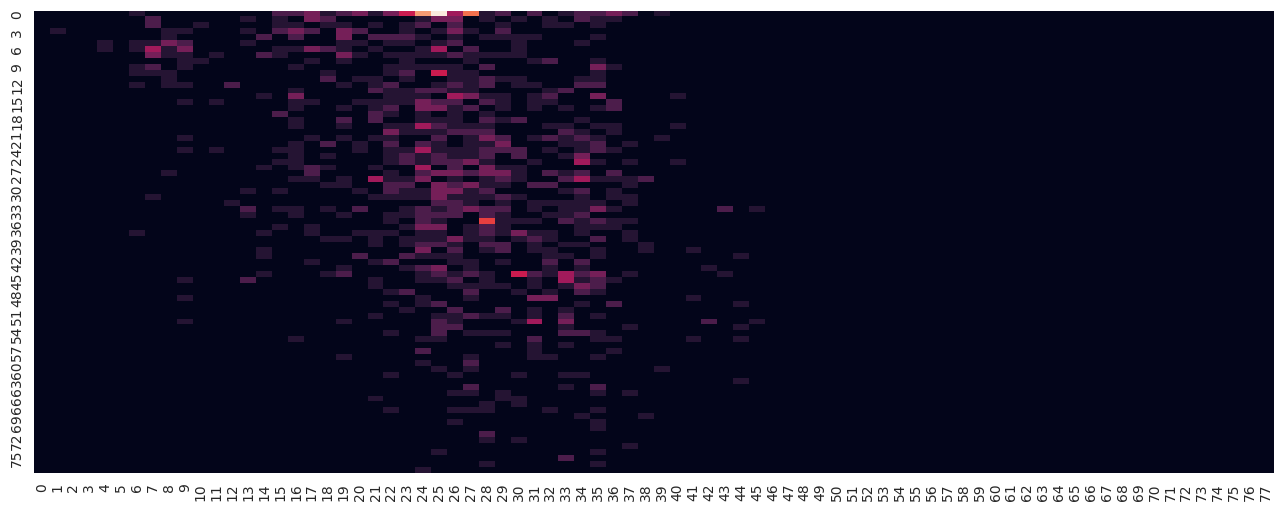

In [24]:
predictions = best_mlp_model_3.predict([X_audio_test, X_genre_test]).flatten().round(0).astype(int)
results = pd.DataFrame([y_test.values, predictions], index=['actual', 'predicted']).T.round(0).astype(int)
results['differences'] = np.abs(results.actual - results.predicted)

sns.heatmap(confusion_matrix(results.actual, results.predicted), cbar=False)

In [25]:
temp = pd.DataFrame(best_mlp_model_3.predict([X_audio_test, X_genre_test]).flatten().round(0).astype(int), index=X_audio_test.index)
true_ranks = y_test.argsort().argsort()
predicted_ranks = temp.iloc[:,0].argsort().argsort()

stats.spearmanr(true_ranks, predicted_ranks)

34/34 [==============================] - 0s 1ms/step


SpearmanrResult(correlation=0.34166995580790904, pvalue=7.938157874182113e-31)

## SHAP on Best Model - LightGBM

In [70]:
import shap

/opt/venv/tf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
explainer = shap.Explainer(rf)
shap_values = explainer(pd.concat([X_train.reset_index(), pd.DataFrame(mel_features_train)], axis=1).set_index('id'))
shap.plots.beeswarm(shap_values)

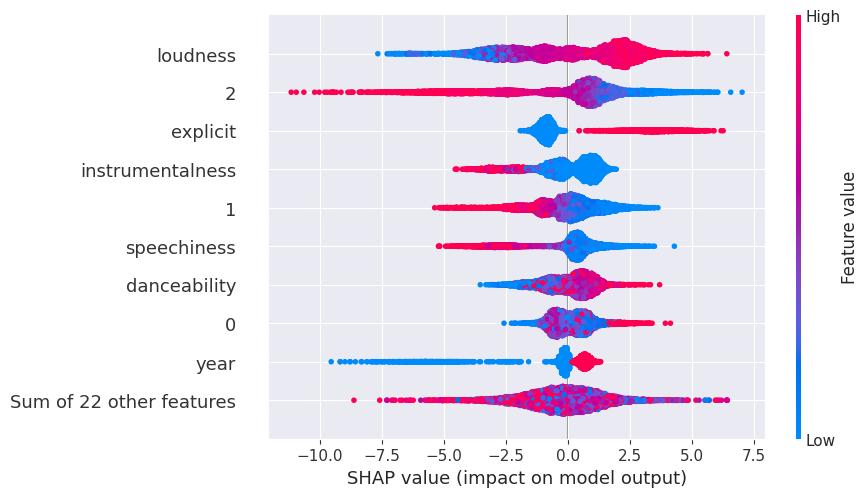

In [11]:
import shap

explainer = shap.Explainer(lgb)
shap_values = explainer(pd.concat([X_audio_train.reset_index(), pd.DataFrame(mel_features_train)], axis=1).set_index('id'))
shap.plots.beeswarm(shap_values)

In [42]:
import shap

explainer = shap.Explainer(lgb)
shap_values = explainer(pd.concat([X_train.reset_index(), pd.DataFrame(mel_features_train)], axis=1).set_index('id'))
shap.plots.beeswarm(shap_values)

/opt/venv/tf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[LightGBM] [Fatal] The number of features in data (51) is not the same as it was in training data (106).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.


LightGBMError: The number of features in data (51) is not the same as it was in training data (106).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.